In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from sklearn.preprocessing import StandardScaler
from time import time
%matplotlib inline

In [38]:
def compareFloats(num1, num2, eps = 0.00001, onlyEquality=True):
    '''
        # Método que compara 2 floats até certa precisão
        # Exemplo:
        # a = 1.55555; b = 1.55566; eps = 0.0001
        # Para o eps acima, a < b, enquanto, para eps = 0.001, a == b
    '''
    subtr = num1-num2
    if subtr < eps:
        return False
    elif onlyEquality:
        return True
    else:
        return 1 if subtr > 0 else -1

In [39]:
def fixTimestamp(ts:str):
    new_ts = ts[:10]+'.'+ts[10:]
    return float(new_ts)

In [40]:
def getData(date_str:str):
    date = dt.strptime(date_str, '%Y-%m-%d')
    return date

In [41]:
dataset = pd.read_csv('testdata.csv')

In [42]:
dataset.head()

,user,latitude,longitude,date,day_of_week,hour,categoria,timestamp
0,User_3401,-26.489503,-49.028018,2018-07-08,Saturday,18,bakery,1531604419436
1,User_539,-14.457400,-46.433148,2018-07-08,Sunday,7,restaurant,1531650749377
2,User_789,-8.903859,-36.487485,2018-07-08,Saturday,9,night_club,1531571345816
3,User_2814,-22.823960,-43.012243,2018-07-08,Saturday,22,store,1531619273330
4,User_3432,-24.949576,-53.488507,2018-07-08,Sunday,3,restaurant,1531634482205


<h1>Análise dos Dados</h1>
<p>Inicialmente podemos analisar o dataset buscando valores únicos que podem retornar algum insight.</p>

<h2>Limpando o Dataset</h2>
<p>Através de algumas análises de colunas, notei que alguns valores são irelevantes:</p>
<ul>
    <li>Posso substituir a coluna de data por uma só contendo os dias do mês. Todas as datas são do mês 7</li>
    <li>Timestamp é irelevante dado que a tabela já contém dia, mês, ano, dia da semana e hora. A única relevancia seria especificar ainda mais além do que já é dado. Além disso o timestamp não está bem formatado e, tentando corrigir, as datas não batem com o que é dado nas outras colunas</li>
</ul>

In [43]:
curr_timestamp = time()
first_timestamp_ds = dataset['timestamp'][0]
print('Comparando Timestamps:')
print('%f\n%.d'%(curr_timestamp, first_timestamp_ds))

Comparando Timestamps:
1532019127.071683
1531604419436


<p>Comparando o tamanho dos dois notei que o timestamp do dataset não possui decimal, porém é 4 dígitos maior do que um timestamp correto. Deduzi que esses dígitos a mais seria decimal. Então consertei e comparei a data com o novo timestamp e a data presente no dataset:</p>

In [44]:
for _, row in dataset[['hour','date','timestamp']].iterrows():
    datetime_ts = dt.utcfromtimestamp(row['timestamp']/1000)
    print(datetime_ts.date(), datetime_ts.hour, end = '\t')
    print(row['date'], row['hour'])

2018-07-14 21	2018-07-08 18
2018-07-15 10	2018-07-08 7
2018-07-14 12	2018-07-08 9
2018-07-15 1	2018-07-08 22
2018-07-15 6	2018-07-08 3
2018-07-15 6	2018-07-03 3
2018-07-14 23	2018-07-03 20
2018-07-15 15	2018-07-02 12
2018-07-15 13	2018-07-03 10
2018-07-15 15	2018-07-03 12
2018-07-15 16	2018-07-03 13
2018-07-15 2	2018-07-03 22
2018-07-14 23	2018-07-15 20
2018-07-15 16	2018-07-15 13
2018-07-15 16	2018-07-15 13
2018-07-15 11	2018-07-15 8
2018-07-15 16	2018-07-15 13
2018-07-15 16	2018-07-09 13
2018-07-15 23	2018-07-09 20
2018-07-15 21	2018-07-09 18
2018-07-15 1	2018-07-09 22
2018-07-15 21	2018-07-09 18
2018-07-15 18	2018-07-09 15
2018-07-15 21	2018-07-09 18
2018-07-15 11	2018-07-09 8
2018-07-15 20	2018-07-09 17
2018-07-13 11	2018-07-10 8
2018-07-13 12	2018-07-10 9
2018-07-13 0	2018-07-10 21
2018-07-12 19	2018-07-10 16
2018-07-13 0	2018-07-10 21
2018-07-13 0	2018-07-10 21
2018-07-11 19	2018-07-11 16
2018-07-07 16	2018-07-11 13
2018-07-13 10	2018-07-10 7
2018-07-13 11	2018-07-11 8
2018-07-13

2018-07-04 22	2018-07-13 19
2018-07-05 11	2018-07-12 8
2018-07-05 11	2018-07-12 8
2018-07-05 11	2018-07-12 8
2018-07-05 12	2018-07-12 9
2018-07-05 11	2018-07-13 8
2018-07-05 12	2018-07-13 9
2018-07-05 12	2018-07-13 9
2018-07-05 12	2018-07-09 9
2018-07-05 16	2018-07-10 13
2018-07-05 16	2018-07-10 13
2018-07-05 16	2018-07-10 13
2018-07-05 16	2018-07-10 14
2018-07-05 16	2018-07-11 13
2018-07-05 16	2018-07-11 13
2018-07-05 17	2018-07-11 14
2018-07-05 17	2018-07-11 14
2018-07-05 9	2018-07-11 6
2018-07-05 4	2018-07-10 1
2018-07-05 5	2018-07-10 2
2018-07-12 11	2018-07-10 8
2018-07-12 11	2018-07-10 8
2018-07-12 11	2018-07-11 8
2018-07-12 11	2018-07-10 8
2018-07-10 5	2018-07-10 2
2018-07-12 11	2018-07-10 8
2018-07-12 0	2018-07-10 21
2018-07-12 0	2018-07-10 21
2018-07-11 15	2018-07-09 12
2018-07-12 11	2018-07-09 8
2018-07-12 11	2018-07-09 8
2018-07-12 12	2018-07-09 9
2018-07-12 11	2018-07-09 8
2018-07-11 11	2018-07-09 8
2018-07-12 0	2018-07-09 21
2018-07-11 12	2018-07-09 8
2018-07-11 15	2018-07-

2018-07-14 11	2018-07-03 8
2018-07-14 13	2018-07-03 10
2018-07-14 12	2018-07-03 9
2018-07-14 13	2018-07-03 10
2018-07-14 12	2018-07-03 9
2018-07-13 13	2018-07-03 10
2018-07-13 13	2018-07-03 10
2018-07-13 14	2018-07-03 11
2018-07-13 13	2018-07-03 10
2018-07-13 13	2018-07-03 10
2018-07-13 13	2018-07-03 10
2018-07-13 13	2018-07-03 10
2018-07-13 7	2018-07-03 4
2018-07-13 10	2018-07-03 7
2018-07-13 12	2018-07-03 9
2018-07-13 13	2018-07-03 10
2018-07-13 13	2018-07-03 10
2018-07-13 11	2018-07-03 8
2018-07-13 13	2018-07-03 10
2018-07-13 13	2018-07-03 10
2018-07-13 20	2018-07-03 17
2018-07-13 13	2018-07-03 10
2018-07-13 13	2018-07-03 10
2018-07-13 12	2018-07-03 9
2018-07-12 16	2018-07-01 13
2018-07-13 3	2018-07-01 0
2018-07-12 12	2018-07-01 9
2018-07-11 17	2018-07-01 14
2018-07-12 21	2018-07-01 18
2018-07-13 3	2018-07-01 0
2018-07-12 16	2018-07-01 13
2018-07-12 10	2018-07-01 7
2018-07-13 2	2018-07-01 23
2018-07-13 2	2018-07-01 23
2018-07-13 2	2018-07-01 23
2018-07-13 3	2018-07-01 23
2018-07-13 

2018-07-01 21	2018-07-02 18
2018-07-01 4	2018-07-01 1
2018-07-01 7	2018-07-02 4
2018-07-01 8	2018-07-02 5
2018-07-10 1	2018-07-02 22
2018-07-10 3	2018-07-02 0
2018-07-10 2	2018-07-02 23
2018-07-10 2	2018-07-02 23
2018-07-10 0	2018-07-02 21
2018-07-09 22	2018-07-02 19
2018-07-10 0	2018-07-02 21
2018-07-10 0	2018-07-02 21
2018-07-09 6	2018-07-02 3
2018-07-10 0	2018-07-02 21
2018-07-09 18	2018-07-02 15
2018-07-09 23	2018-07-02 20
2018-07-09 17	2018-07-02 14
2018-07-09 21	2018-07-02 18
2018-07-10 0	2018-07-02 21
2018-07-09 18	2018-07-02 15
2018-07-09 23	2018-07-13 20
2018-07-10 0	2018-07-12 21
2018-07-10 0	2018-07-12 21
2018-07-10 9	2018-07-12 6
2018-07-10 9	2018-07-12 6
2018-07-10 3	2018-07-12 0
2018-07-10 10	2018-07-12 7
2018-07-09 13	2018-07-12 10
2018-07-10 10	2018-07-12 7
2018-07-10 10	2018-07-13 7
2018-07-05 23	2018-07-13 20
2018-07-05 23	2018-07-13 20
2018-07-05 23	2018-07-13 20
2018-07-03 3	2018-07-13 0
2018-07-03 18	2018-07-13 15
2018-07-05 1	2018-07-13 22
2018-07-05 12	2018-07-13

2018-07-11 10	2018-07-09 7
2018-07-11 12	2018-07-09 9
2018-07-05 0	2018-07-09 21
2018-07-05 10	2018-07-09 7
2018-07-05 10	2018-07-09 7
2018-07-05 9	2018-07-07 6
2018-07-05 9	2018-07-09 6
2018-07-05 10	2018-07-09 7
2018-07-05 10	2018-07-09 7
2018-07-05 10	2018-07-09 7
2018-07-04 22	2018-07-09 19
2018-07-05 0	2018-07-08 21
2018-07-05 10	2018-07-09 7
2018-07-05 12	2018-07-09 9
2018-07-04 18	2018-07-09 15
2018-07-05 12	2018-07-09 8
2018-07-05 12	2018-07-09 9
2018-07-05 11	2018-07-09 8
2018-07-05 11	2018-07-09 8
2018-07-05 11	2018-07-10 8
2018-07-05 11	2018-07-10 8
2018-07-05 11	2018-07-10 7
2018-07-05 11	2018-07-10 8
2018-07-05 12	2018-07-11 9
2018-07-05 12	2018-07-11 9
2018-07-05 12	2018-07-10 9
2018-07-05 11	2018-07-10 8
2018-07-04 15	2018-07-10 12
2018-07-05 11	2018-07-10 8
2018-07-05 11	2018-07-10 8
2018-07-05 11	2018-07-10 8
2018-07-05 11	2018-07-11 8
2018-07-05 11	2018-07-11 8
2018-07-05 11	2018-07-11 8
2018-07-05 12	2018-07-11 9
2018-07-05 12	2018-07-11 9
2018-07-05 12	2018-07-11 9


2018-07-06 1	2018-07-05 22
2018-07-06 1	2018-07-04 22
2018-07-06 1	2018-07-05 23
2018-07-06 1	2018-07-05 22
2018-07-06 1	2018-07-05 22
2018-07-06 1	2018-07-05 21
2018-07-06 0	2018-07-05 21
2018-07-06 0	2018-07-05 21
2018-07-06 1	2018-07-05 22
2018-07-06 1	2018-07-05 22
2018-07-05 23	2018-07-05 19
2018-07-06 1	2018-07-05 21
2018-07-05 22	2018-07-05 19
2018-07-06 1	2018-07-05 22
2018-07-06 1	2018-07-05 22
2018-07-06 17	2018-07-05 13
2018-07-06 13	2018-07-05 10
2018-07-06 20	2018-07-05 17
2018-07-01 17	2018-07-05 14
2018-07-01 20	2018-07-05 17
2018-07-01 20	2018-07-05 17
2018-07-01 14	2018-07-04 11
2018-07-01 15	2018-07-04 12
2018-07-01 14	2018-07-05 11
2018-07-01 14	2018-07-05 11
2018-07-01 15	2018-07-05 12
2018-07-01 15	2018-07-05 13
2018-07-01 15	2018-07-06 12
2018-07-01 12	2018-07-05 9
2018-07-01 15	2018-07-06 12
2018-07-01 15	2018-07-06 12
2018-07-01 11	2018-07-05 8
2018-07-01 11	2018-07-05 8
2018-07-01 15	2018-07-06 12
2018-07-01 14	2018-07-06 10
2018-07-01 13	2018-07-06 10
2018-07-

2018-07-04 13	2018-07-07 10
2018-07-04 12	2018-07-07 9
2018-07-03 19	2018-07-07 16
2018-07-04 12	2018-07-07 9
2018-07-04 13	2018-07-07 10
2018-07-04 13	2018-07-08 10
2018-07-04 13	2018-07-10 10
2018-07-04 12	2018-07-10 9
2018-07-04 13	2018-07-10 10
2018-07-04 12	2018-07-10 7
2018-07-03 22	2018-07-10 19
2018-07-03 10	2018-07-10 7
2018-07-04 13	2018-07-10 10
2018-07-04 12	2018-07-10 9
2018-07-04 12	2018-07-10 9
2018-07-04 13	2018-07-10 10
2018-07-04 10	2018-07-10 7
2018-07-04 10	2018-07-10 7
2018-07-04 12	2018-07-10 9
2018-07-04 13	2018-07-10 10
2018-07-04 13	2018-07-09 10
2018-07-03 18	2018-07-10 15
2018-07-04 10	2018-07-09 7
2018-07-04 13	2018-07-10 10
2018-07-04 13	2018-07-10 10
2018-07-04 13	2018-07-10 10
2018-07-04 11	2018-07-10 8
2018-07-04 3	2018-07-10 0
2018-07-04 11	2018-07-10 8
2018-07-04 11	2018-07-10 8
2018-07-04 11	2018-07-10 8
2018-07-04 8	2018-07-10 5
2018-07-04 12	2018-07-10 9
2018-07-04 6	2018-07-10 3
2018-07-04 12	2018-07-10 9
2018-07-04 12	2018-07-10 9
2018-07-01 15	20

2018-07-11 15	2018-07-04 12
2018-07-11 14	2018-07-04 11
2018-07-11 15	2018-07-04 11
2018-07-11 15	2018-07-04 12
2018-07-01 22	2018-07-04 19
2018-07-01 19	2018-07-03 16
2018-07-01 22	2018-07-04 19
2018-07-01 19	2018-07-03 16
2018-07-01 20	2018-07-04 17
2018-07-01 20	2018-07-04 17
2018-07-01 21	2018-07-01 18
2018-07-01 20	2018-07-01 17
2018-07-01 19	2018-07-01 16
2018-07-01 18	2018-07-01 15
2018-07-01 22	2018-07-01 19
2018-07-01 22	2018-07-01 19
2018-07-01 20	2018-07-01 17
2018-07-01 19	2018-07-01 16
2018-07-01 20	2018-07-01 17
2018-07-01 21	2018-07-01 18
2018-07-01 19	2018-07-01 16
2018-07-01 21	2018-07-01 18
2018-07-01 21	2018-07-01 17
2018-07-01 22	2018-07-01 18
2018-07-01 16	2018-07-01 13
2018-07-01 16	2018-07-01 13
2018-07-01 23	2018-07-01 20
2018-07-01 23	2018-07-02 20
2018-07-01 20	2018-07-02 17
2018-07-01 20	2018-07-02 16
2018-07-01 20	2018-07-02 17
2018-07-01 21	2018-07-02 18
2018-07-01 21	2018-07-02 18
2018-07-01 21	2018-07-02 18
2018-07-01 21	2018-07-02 18
2018-07-01 14	2018-0

2018-07-01 21	2018-07-02 18
2018-07-01 19	2018-07-03 15
2018-07-01 12	2018-07-03 9
2018-07-08 0	2018-07-03 21
2018-07-08 0	2018-07-03 21
2018-07-06 14	2018-07-03 11
2018-07-08 0	2018-07-03 21
2018-07-08 18	2018-07-03 15
2018-07-08 19	2018-07-02 16
2018-07-08 20	2018-07-03 17
2018-07-08 20	2018-07-03 18
2018-07-08 20	2018-07-03 17
2018-07-08 6	2018-07-03 3
2018-07-07 18	2018-07-02 15
2018-07-08 7	2018-07-03 4
2018-07-07 20	2018-07-03 17
2018-07-08 8	2018-07-03 5
2018-07-07 15	2018-07-03 12
2018-07-08 10	2018-07-03 7
2018-07-08 10	2018-07-03 7
2018-07-08 11	2018-07-03 8
2018-07-07 23	2018-07-03 20
2018-07-08 10	2018-07-03 7
2018-07-08 1	2018-07-03 22
2018-07-08 10	2018-07-03 7
2018-07-07 23	2018-07-03 20
2018-07-05 19	2018-07-03 17
2018-07-07 21	2018-07-03 17
2018-07-08 15	2018-07-03 12
2018-07-08 19	2018-07-03 17
2018-07-08 20	2018-07-03 17
2018-07-08 13	2018-07-07 10
2018-07-03 0	2018-07-07 20
2018-07-03 2	2018-07-07 23
2018-07-03 2	2018-07-07 23
2018-07-03 2	2018-07-07 23
2018-07-01 2

2018-07-15 20	2018-07-12 17
2018-07-14 18	2018-07-13 15
2018-07-15 20	2018-07-11 17
2018-07-15 0	2018-07-13 21
2018-07-15 0	2018-07-13 20
2018-07-15 0	2018-07-13 21
2018-07-15 0	2018-07-13 21
2018-07-15 0	2018-07-13 21
2018-07-15 0	2018-07-12 21
2018-07-14 3	2018-07-12 0
2018-07-15 0	2018-07-13 21
2018-07-15 0	2018-07-13 21
2018-07-05 16	2018-07-13 13
2018-07-06 9	2018-07-13 6
2018-07-06 5	2018-07-12 2
2018-07-05 23	2018-07-13 20
2018-07-03 22	2018-07-01 19
2018-07-06 23	2018-07-01 20
2018-07-06 23	2018-07-09 20
2018-07-06 23	2018-07-09 20
2018-07-06 0	2018-07-08 21
2018-07-05 19	2018-07-09 16
2018-07-06 19	2018-07-09 16
2018-07-06 18	2018-07-09 15
2018-07-06 20	2018-07-09 17
2018-07-06 20	2018-07-09 17
2018-07-06 16	2018-07-09 13
2018-07-06 8	2018-07-09 5
2018-07-06 9	2018-07-09 6
2018-07-03 15	2018-07-09 12
2018-07-03 15	2018-07-09 12
2018-07-03 16	2018-07-09 13
2018-07-03 16	2018-07-09 13
2018-07-03 15	2018-07-09 12
2018-07-03 15	2018-07-09 12
2018-07-03 15	2018-07-09 12
2018-07-03 

2018-07-12 3	2018-07-01 0
2018-07-06 16	2018-07-01 13
2018-07-06 14	2018-07-01 11
2018-07-06 16	2018-07-01 14
2018-07-06 14	2018-07-01 11
2018-07-06 16	2018-07-01 13
2018-07-06 16	2018-07-01 13
2018-07-06 16	2018-07-09 13
2018-07-06 16	2018-07-09 13
2018-07-06 15	2018-07-09 12
2018-07-06 16	2018-07-09 13
2018-07-06 16	2018-07-09 12
2018-07-06 16	2018-07-09 13
2018-07-06 16	2018-07-09 13
2018-07-06 16	2018-07-09 13
2018-07-06 16	2018-07-09 13
2018-07-06 15	2018-07-09 12
2018-07-06 17	2018-07-09 14
2018-07-06 17	2018-07-09 14
2018-07-06 16	2018-07-09 13
2018-07-06 16	2018-07-09 13
2018-07-06 15	2018-07-09 12
2018-07-06 11	2018-07-08 8
2018-07-06 16	2018-07-08 13
2018-07-06 16	2018-07-09 13
2018-07-06 11	2018-07-09 8
2018-07-06 16	2018-07-09 13
2018-07-06 14	2018-07-09 11
2018-07-06 15	2018-07-08 12
2018-07-06 16	2018-07-09 13
2018-07-06 15	2018-07-09 12
2018-07-06 16	2018-07-08 13
2018-07-06 14	2018-07-09 11
2018-07-05 2	2018-07-02 23
2018-07-06 16	2018-07-02 13
2018-07-02 15	2018-07-02 

2018-07-06 16	2018-07-13 13
2018-07-13 1	2018-07-14 22
2018-07-13 0	2018-07-14 21
2018-07-13 1	2018-07-14 22
2018-07-12 11	2018-07-14 8
2018-07-13 1	2018-07-14 22
2018-07-13 1	2018-07-14 22
2018-07-13 2	2018-07-14 23
2018-07-13 1	2018-07-14 22
2018-07-13 1	2018-07-14 22
2018-07-13 1	2018-07-14 22
2018-07-12 11	2018-07-14 8
2018-07-13 1	2018-07-14 22
2018-07-13 1	2018-07-14 22
2018-07-13 1	2018-07-14 22
2018-07-12 22	2018-07-14 19
2018-07-13 0	2018-07-14 21
2018-07-12 23	2018-07-14 20
2018-07-09 21	2018-07-14 18
2018-07-13 1	2018-07-14 22
2018-07-12 23	2018-07-14 20
2018-07-13 0	2018-07-14 21
2018-07-12 17	2018-07-12 14
2018-07-12 18	2018-07-12 16
2018-07-12 22	2018-07-12 18
2018-07-13 1	2018-07-13 22
2018-07-13 1	2018-07-12 22
2018-07-12 22	2018-07-11 19
2018-07-13 2	2018-07-12 23
2018-07-12 17	2018-07-12 14
2018-07-12 13	2018-07-13 10
2018-07-05 1	2018-07-13 22
2018-07-05 1	2018-07-13 22
2018-07-05 1	2018-07-13 22
2018-07-04 16	2018-07-13 13
2018-07-05 1	2018-07-13 22
2018-07-04 0	201

2018-07-07 7	2018-07-12 4
2018-07-07 10	2018-07-12 7
2018-07-07 10	2018-07-12 7
2018-07-07 10	2018-07-12 7
2018-07-07 13	2018-07-11 10
2018-07-07 13	2018-07-11 10
2018-07-07 13	2018-07-12 10
2018-07-07 13	2018-07-12 10
2018-07-07 13	2018-07-12 9
2018-07-07 12	2018-07-12 9
2018-07-07 13	2018-07-12 9
2018-07-07 13	2018-07-12 9
2018-07-07 13	2018-07-12 10
2018-07-07 13	2018-07-12 10
2018-07-05 11	2018-07-12 8
2018-07-06 20	2018-07-12 17
2018-07-07 1	2018-07-12 22
2018-07-06 23	2018-07-12 20
2018-07-06 19	2018-07-12 16
2018-07-01 21	2018-07-12 18
2018-07-01 22	2018-07-12 19
2018-07-01 22	2018-07-12 19
2018-07-01 23	2018-07-12 20
2018-07-01 23	2018-07-11 20
2018-07-01 23	2018-07-11 20
2018-07-01 19	2018-07-11 16
2018-07-01 20	2018-07-11 17
2018-07-01 22	2018-07-11 19
2018-07-01 22	2018-07-11 19
2018-07-01 21	2018-07-04 18
2018-07-01 22	2018-07-04 19
2018-07-01 22	2018-07-04 19
2018-07-01 23	2018-07-04 20
2018-07-01 2	2018-07-04 1
2018-07-01 13	2018-07-04 10
2018-07-01 14	2018-07-04 11
2018-

2018-07-12 21	2018-07-10 18
2018-07-12 20	2018-07-10 17
2018-07-12 21	2018-07-10 18
2018-07-12 21	2018-07-10 18
2018-07-12 21	2018-07-10 18
2018-07-12 21	2018-07-10 17
2018-07-12 15	2018-07-10 12
2018-07-12 21	2018-07-10 18
2018-07-12 16	2018-07-10 13
2018-07-12 16	2018-07-10 13
2018-07-12 16	2018-07-10 13
2018-07-04 10	2018-07-01 7
2018-07-04 11	2018-07-09 8
2018-07-04 8	2018-07-09 5
2018-07-04 11	2018-07-09 8
2018-07-04 11	2018-07-09 8
2018-07-04 11	2018-07-09 8
2018-07-04 11	2018-07-09 8
2018-07-04 11	2018-07-09 8
2018-07-04 11	2018-07-09 8
2018-07-04 11	2018-07-09 8
2018-07-04 11	2018-07-09 8
2018-07-04 11	2018-07-09 7
2018-07-03 18	2018-07-09 15
2018-07-04 10	2018-07-09 7
2018-07-04 10	2018-07-09 7
2018-07-04 10	2018-07-09 7
2018-07-04 11	2018-07-09 8
2018-07-04 11	2018-07-08 8
2018-07-04 11	2018-07-09 8
2018-07-04 11	2018-07-09 8
2018-07-04 11	2018-07-09 8
2018-07-04 11	2018-07-09 8
2018-07-04 12	2018-07-09 8
2018-07-04 12	2018-07-09 9
2018-07-04 11	2018-07-09 8
2018-07-04 8	2018

2018-07-05 10	2018-07-04 7
2018-07-04 20	2018-07-04 17
2018-07-05 10	2018-07-07 7
2018-07-05 11	2018-07-07 8
2018-07-05 11	2018-07-07 8
2018-07-05 11	2018-07-07 8
2018-07-05 11	2018-07-07 8
2018-07-04 17	2018-07-07 14
2018-07-05 11	2018-07-06 8
2018-07-04 22	2018-07-07 19
2018-07-05 11	2018-07-07 8
2018-07-05 11	2018-07-07 8
2018-07-05 11	2018-07-07 8
2018-07-05 11	2018-07-07 8
2018-07-05 10	2018-07-07 7
2018-07-05 7	2018-07-07 4
2018-07-05 11	2018-07-07 8
2018-07-05 11	2018-07-07 8
2018-07-05 11	2018-07-07 8
2018-07-05 11	2018-07-07 8
2018-07-05 11	2018-07-07 8
2018-07-05 10	2018-07-07 7
2018-07-05 10	2018-07-07 8
2018-07-05 11	2018-07-07 8
2018-07-05 11	2018-07-07 8
2018-07-05 11	2018-07-07 8
2018-07-05 10	2018-07-07 6
2018-07-05 11	2018-07-14 8
2018-07-05 11	2018-07-14 8
2018-07-05 11	2018-07-14 8
2018-07-05 11	2018-07-14 8
2018-07-05 10	2018-07-14 7
2018-07-05 10	2018-07-14 7
2018-07-05 10	2018-07-14 7
2018-07-04 21	2018-07-14 18
2018-07-05 11	2018-07-14 8
2018-07-05 11	2018-07-14 

2018-07-12 15	2018-07-09 12
2018-07-13 22	2018-07-09 19
2018-07-13 10	2018-07-09 9
2018-07-13 16	2018-07-09 13
2018-07-13 21	2018-07-09 18
2018-07-13 21	2018-07-09 18
2018-07-13 21	2018-07-09 18
2018-07-13 21	2018-07-09 18
2018-07-13 21	2018-07-02 18
2018-07-13 21	2018-07-09 17
2018-07-13 21	2018-07-09 18
2018-07-03 16	2018-07-08 13
2018-07-03 16	2018-07-09 13
2018-07-03 16	2018-07-09 13
2018-07-03 16	2018-07-09 13
2018-07-03 16	2018-07-09 14
2018-07-03 16	2018-07-08 14
2018-07-03 15	2018-07-08 12
2018-07-03 16	2018-07-09 13
2018-07-03 16	2018-07-09 13
2018-07-03 16	2018-07-09 13
2018-07-03 16	2018-07-09 13
2018-07-03 15	2018-07-08 12
2018-07-03 16	2018-07-09 13
2018-07-03 16	2018-07-09 13
2018-07-03 16	2018-07-08 13
2018-07-03 15	2018-07-09 12
2018-07-03 16	2018-07-09 13
2018-07-03 16	2018-07-09 13
2018-07-03 16	2018-07-09 13
2018-07-03 16	2018-07-09 13
2018-07-03 16	2018-07-09 13
2018-07-03 15	2018-07-09 12
2018-07-03 16	2018-07-09 13
2018-07-03 15	2018-07-08 12
2018-07-03 16	2018-07

2018-07-12 8	2018-07-11 5
2018-07-12 4	2018-07-11 1
2018-07-12 7	2018-07-11 4
2018-07-11 12	2018-07-11 8
2018-07-12 6	2018-07-11 2
2018-07-12 1	2018-07-11 22
2018-07-12 0	2018-07-10 21
2018-07-12 1	2018-07-11 22
2018-07-12 1	2018-07-11 22
2018-07-11 0	2018-07-11 21
2018-07-12 1	2018-07-11 22
2018-07-12 1	2018-07-11 22
2018-07-12 1	2018-07-11 22
2018-07-12 1	2018-07-11 22
2018-07-12 1	2018-07-11 22
2018-07-10 18	2018-07-11 15
2018-07-11 3	2018-07-11 0
2018-07-11 1	2018-07-11 22
2018-07-11 2	2018-07-11 23
2018-07-11 10	2018-07-11 7
2018-07-11 10	2018-07-11 7
2018-07-09 20	2018-07-10 17
2018-07-10 22	2018-07-10 19
2018-07-11 9	2018-07-10 6
2018-07-11 5	2018-07-10 2
2018-07-11 12	2018-07-10 9
2018-07-11 12	2018-07-10 9
2018-07-10 22	2018-07-10 19
2018-07-10 18	2018-07-10 14
2018-07-11 9	2018-07-10 6
2018-07-11 8	2018-07-10 5
2018-07-11 8	2018-07-10 5
2018-07-11 8	2018-07-10 5
2018-07-11 9	2018-07-10 5
2018-07-11 11	2018-07-10 8
2018-07-11 10	2018-07-08 7
2018-07-11 12	2018-07-12 9
2018-07-

2018-07-11 23	2018-07-05 20
2018-07-11 23	2018-07-05 20
2018-07-11 22	2018-07-05 19
2018-07-11 23	2018-07-05 20
2018-07-11 23	2018-07-05 20
2018-07-11 23	2018-07-05 20
2018-07-11 10	2018-07-05 7
2018-07-11 10	2018-07-05 7
2018-07-11 11	2018-07-05 8
2018-07-11 10	2018-07-05 7
2018-07-10 20	2018-07-05 17
2018-07-11 11	2018-07-05 8
2018-07-11 11	2018-07-05 8
2018-07-11 11	2018-07-05 8
2018-07-11 22	2018-07-05 19
2018-07-11 3	2018-07-05 0
2018-07-09 22	2018-07-05 19
2018-07-11 3	2018-07-05 0
2018-07-11 15	2018-07-05 11
2018-07-11 23	2018-07-05 19
2018-07-11 23	2018-07-12 20
2018-07-11 23	2018-07-13 20
2018-07-11 23	2018-07-07 20
2018-07-11 23	2018-07-13 20
2018-07-01 11	2018-07-13 8
2018-07-01 17	2018-07-13 15
2018-07-01 19	2018-07-13 16
2018-07-01 16	2018-07-13 13
2018-07-01 20	2018-07-13 18
2018-07-01 20	2018-07-13 17
2018-07-01 19	2018-07-13 16
2018-07-01 15	2018-07-14 12
2018-07-01 19	2018-07-14 16
2018-07-01 19	2018-07-14 16
2018-07-01 19	2018-07-14 16
2018-07-01 8	2018-07-13 5
2018-0

2018-07-09 15	2018-07-01 12
2018-07-01 19	2018-07-01 16
2018-07-01 15	2018-07-08 12
2018-07-01 19	2018-07-08 16
2018-07-01 20	2018-07-08 17
2018-07-01 16	2018-07-08 13
2018-07-01 19	2018-07-08 16
2018-07-01 20	2018-07-08 17
2018-07-01 16	2018-07-08 13
2018-07-01 17	2018-07-08 14
2018-07-01 17	2018-07-08 14
2018-07-01 19	2018-07-08 16
2018-07-01 19	2018-07-08 16
2018-07-01 20	2018-07-08 17
2018-07-01 15	2018-07-08 12
2018-07-01 15	2018-07-08 12
2018-07-01 20	2018-07-08 17
2018-07-01 19	2018-07-08 16
2018-07-01 19	2018-07-08 16
2018-07-01 19	2018-07-08 16
2018-07-01 19	2018-07-08 16
2018-07-01 20	2018-07-08 17
2018-07-01 19	2018-07-08 16
2018-07-01 18	2018-07-08 15
2018-07-01 19	2018-07-08 16
2018-07-01 19	2018-07-08 16
2018-07-01 19	2018-07-08 16
2018-07-01 17	2018-07-06 14
2018-07-01 20	2018-07-08 16
2018-07-01 20	2018-07-08 17
2018-07-01 20	2018-07-06 17
2018-07-01 18	2018-07-07 15
2018-07-01 19	2018-07-09 16
2018-07-01 17	2018-07-09 14
2018-07-01 8	2018-07-08 5
2018-07-01 4	2018-07-0

2018-07-02 22	2018-07-10 19
2018-07-02 18	2018-07-10 15
2018-07-02 23	2018-07-10 20
2018-07-01 12	2018-07-10 9
2018-07-02 0	2018-07-10 21
2018-07-02 0	2018-07-02 21
2018-07-02 2	2018-07-10 23
2018-07-02 1	2018-07-10 22
2018-07-02 2	2018-07-10 23
2018-07-01 22	2018-07-10 19
2018-07-02 1	2018-07-10 22
2018-07-02 0	2018-07-10 21
2018-07-04 8	2018-07-10 5
2018-07-04 7	2018-07-03 4
2018-07-03 16	2018-07-03 13
2018-07-04 8	2018-07-03 5
2018-07-04 7	2018-07-03 4
2018-07-03 22	2018-07-03 19
2018-07-04 21	2018-07-03 18
2018-07-04 21	2018-07-03 18
2018-07-04 22	2018-07-03 19
2018-07-04 21	2018-07-03 18
2018-07-04 21	2018-07-03 18
2018-07-04 21	2018-07-03 18
2018-07-04 21	2018-07-02 18
2018-07-04 21	2018-07-03 18
2018-07-04 21	2018-07-03 18
2018-07-03 13	2018-07-03 10
2018-07-03 10	2018-07-03 7
2018-07-04 21	2018-07-03 18
2018-07-04 16	2018-07-03 13
2018-07-04 21	2018-07-03 18
2018-07-04 21	2018-07-03 18
2018-07-04 21	2018-07-03 18
2018-07-04 22	2018-07-03 19
2018-07-04 22	2018-07-03 18
2018-07-0

2018-07-09 19	2018-07-07 16
2018-07-09 19	2018-07-07 16
2018-07-09 19	2018-07-06 16
2018-07-06 12	2018-07-06 9
2018-07-09 20	2018-07-06 17
2018-07-09 16	2018-07-06 13
2018-07-09 20	2018-07-06 17
2018-07-09 20	2018-07-06 17
2018-07-09 20	2018-07-06 17
2018-07-09 20	2018-07-06 17
2018-07-09 20	2018-07-06 17
2018-07-09 20	2018-07-06 17
2018-07-09 19	2018-07-06 16
2018-07-09 14	2018-07-06 11
2018-07-09 20	2018-07-06 17
2018-07-09 20	2018-07-06 17
2018-07-09 20	2018-07-06 17
2018-07-09 20	2018-07-06 17
2018-07-09 20	2018-07-06 17
2018-07-09 20	2018-07-06 16
2018-07-09 20	2018-07-06 17
2018-07-09 20	2018-07-05 17
2018-07-09 16	2018-07-06 13
2018-07-09 20	2018-07-06 17
2018-07-09 20	2018-07-05 17
2018-07-09 20	2018-07-06 17
2018-07-09 20	2018-07-06 17
2018-07-10 7	2018-07-06 4
2018-07-10 3	2018-07-06 0
2018-07-09 17	2018-07-06 14
2018-07-09 22	2018-07-06 19
2018-07-10 1	2018-07-06 22
2018-07-09 21	2018-07-06 18
2018-07-09 19	2018-07-06 16
2018-07-09 22	2018-07-06 19
2018-07-10 10	2018-07-06 7

2018-07-01 9	2018-07-09 6
2018-07-01 19	2018-07-06 16
2018-07-01 13	2018-07-09 10
2018-07-01 11	2018-07-09 9
2018-07-01 14	2018-07-09 11
2018-07-01 19	2018-07-09 16
2018-07-01 20	2018-07-09 17
2018-07-01 14	2018-07-09 10
2018-07-01 14	2018-07-09 11
2018-07-01 8	2018-07-09 5
2018-07-12 16	2018-07-09 13
2018-07-12 16	2018-07-09 13
2018-07-11 23	2018-07-09 20
2018-07-12 13	2018-07-09 10
2018-07-12 12	2018-07-09 9
2018-07-12 21	2018-07-09 18
2018-07-12 21	2018-07-08 18
2018-07-12 21	2018-07-09 18
2018-07-12 21	2018-07-09 18
2018-07-12 20	2018-07-09 17
2018-07-12 22	2018-07-04 19
2018-07-12 11	2018-07-04 8
2018-07-12 15	2018-07-04 12
2018-07-12 17	2018-07-03 14
2018-07-12 21	2018-07-04 18
2018-07-12 21	2018-07-04 18
2018-07-12 20	2018-07-04 17
2018-07-12 19	2018-07-04 16
2018-07-12 22	2018-07-04 19
2018-07-12 21	2018-07-04 18
2018-07-12 18	2018-07-04 15
2018-07-12 20	2018-07-04 17
2018-07-12 21	2018-07-04 18
2018-07-12 21	2018-07-04 18
2018-07-12 21	2018-07-04 18
2018-07-13 18	2018-07-04 15

2018-07-06 18	2018-07-06 15
2018-07-06 18	2018-07-06 15
2018-07-06 18	2018-07-06 15
2018-07-06 18	2018-07-06 15
2018-07-06 19	2018-07-06 16
2018-07-06 19	2018-07-05 16
2018-07-06 10	2018-07-05 7
2018-07-06 10	2018-07-06 7
2018-07-06 9	2018-07-06 6
2018-07-06 10	2018-07-06 7
2018-07-05 2	2018-07-06 23
2018-07-06 10	2018-07-06 7
2018-07-13 17	2018-07-06 14
2018-07-13 17	2018-07-06 14
2018-07-13 17	2018-07-06 14
2018-07-13 16	2018-07-06 13
2018-07-13 17	2018-07-06 13
2018-07-13 15	2018-07-06 12
2018-07-13 15	2018-07-06 12
2018-07-13 17	2018-07-06 13
2018-07-13 17	2018-07-06 14
2018-07-13 16	2018-07-06 13
2018-07-13 17	2018-07-06 14
2018-07-13 17	2018-07-06 14
2018-07-13 17	2018-07-05 14
2018-07-13 17	2018-07-06 14
2018-07-13 16	2018-07-05 13
2018-07-13 16	2018-07-06 13
2018-07-13 15	2018-07-06 12
2018-07-13 14	2018-07-06 11
2018-07-13 16	2018-07-06 13
2018-07-13 17	2018-07-06 13
2018-07-12 14	2018-07-06 11
2018-07-14 6	2018-07-06 3
2018-07-13 17	2018-07-06 14
2018-07-13 17	2018-07-06 14
2

2018-07-15 8	2018-07-15 5
2018-07-15 8	2018-07-15 5
2018-07-13 10	2018-07-15 7
2018-07-15 9	2018-07-15 6
2018-07-15 8	2018-07-15 5
2018-07-15 8	2018-07-15 5
2018-07-14 22	2018-07-15 19
2018-07-14 23	2018-07-15 20
2018-07-14 19	2018-07-15 15
2018-07-15 19	2018-07-07 16
2018-07-15 18	2018-07-07 15
2018-07-15 19	2018-07-07 16
2018-07-15 13	2018-07-07 10
2018-07-15 13	2018-07-07 10
2018-07-15 11	2018-07-07 8
2018-07-15 14	2018-07-07 11
2018-07-15 14	2018-07-07 11
2018-07-10 1	2018-07-07 22
2018-07-09 22	2018-07-06 19
2018-07-09 22	2018-07-07 19
2018-07-10 0	2018-07-07 21
2018-07-09 14	2018-07-07 11
2018-07-09 19	2018-07-07 16
2018-07-10 1	2018-07-07 22
2018-07-10 1	2018-07-07 22
2018-07-10 1	2018-07-07 22
2018-07-10 1	2018-07-07 22
2018-07-10 1	2018-07-07 22
2018-07-10 2	2018-07-06 23
2018-07-09 11	2018-07-06 8
2018-07-10 1	2018-07-07 21
2018-07-10 1	2018-07-07 22
2018-07-10 1	2018-07-06 23
2018-07-10 1	2018-07-07 22
2018-07-09 15	2018-07-06 12
2018-07-10 0	2018-07-06 21
2018-07-10 1	2018-

2018-07-05 16	2018-07-09 12
2018-07-05 17	2018-07-10 14
2018-07-05 16	2018-07-10 13
2018-07-05 18	2018-07-10 15
2018-07-05 18	2018-07-10 15
2018-07-01 4	2018-07-10 1
2018-07-01 4	2018-07-10 1
2018-07-01 4	2018-07-10 1
2018-07-01 4	2018-07-10 1
2018-07-01 5	2018-07-10 2
2018-07-01 4	2018-07-10 1
2018-07-01 4	2018-07-10 1
2018-07-01 4	2018-07-10 1
2018-07-01 14	2018-07-10 11
2018-07-01 13	2018-07-10 10
2018-07-01 13	2018-07-10 10
2018-07-01 13	2018-07-10 10
2018-07-01 13	2018-07-10 10
2018-07-01 14	2018-07-10 11
2018-07-01 18	2018-07-10 13
2018-07-01 18	2018-07-10 15
2018-07-01 17	2018-07-10 14
2018-07-01 17	2018-07-08 14
2018-07-12 15	2018-07-07 12
2018-07-12 15	2018-07-07 12
2018-07-12 15	2018-07-07 12
2018-07-12 15	2018-07-07 12
2018-07-11 16	2018-07-07 12
2018-07-12 16	2018-07-07 13
2018-07-12 16	2018-07-07 13
2018-07-12 16	2018-07-07 13
2018-07-12 23	2018-07-07 20
2018-07-12 16	2018-07-07 13
2018-07-12 16	2018-07-07 13
2018-07-12 16	2018-07-07 13
2018-07-12 14	2018-07-07 11
2018-07-

2018-07-14 19	2018-07-05 16
2018-07-09 10	2018-07-05 7
2018-07-09 11	2018-07-05 8
2018-07-09 15	2018-07-05 12
2018-07-09 14	2018-07-05 11
2018-07-09 15	2018-07-05 12
2018-07-09 15	2018-07-05 12
2018-07-09 14	2018-07-11 11
2018-07-09 13	2018-07-11 10
2018-07-09 16	2018-07-11 13
2018-07-09 16	2018-07-10 12
2018-07-09 10	2018-07-11 8
2018-07-09 16	2018-07-11 12
2018-07-09 16	2018-07-11 13
2018-07-09 15	2018-07-11 12
2018-07-09 16	2018-07-11 13
2018-07-08 16	2018-07-11 13
2018-07-09 16	2018-07-10 13
2018-07-09 16	2018-07-11 13
2018-07-09 14	2018-07-11 11
2018-07-09 15	2018-07-11 12
2018-07-09 14	2018-07-11 11
2018-07-09 15	2018-07-11 12
2018-07-09 15	2018-07-11 12
2018-07-09 14	2018-07-11 11
2018-07-08 20	2018-07-11 17
2018-07-06 9	2018-07-11 6
2018-07-08 3	2018-07-11 0
2018-07-09 15	2018-07-11 12
2018-07-09 15	2018-07-11 12
2018-07-09 15	2018-07-11 12
2018-07-09 15	2018-07-11 12
2018-07-09 15	2018-07-11 12
2018-07-09 16	2018-07-11 13
2018-07-09 16	2018-07-11 13
2018-07-09 15	2018-07-11 12

2018-07-10 19	2018-07-10 16
2018-07-09 10	2018-07-10 7
2018-07-10 19	2018-07-10 16
2018-07-10 12	2018-07-10 9
2018-07-10 16	2018-07-10 13
2018-07-10 18	2018-07-10 15
2018-07-10 17	2018-07-10 14
2018-07-11 0	2018-07-10 21
2018-07-10 18	2018-07-10 15
2018-07-06 13	2018-07-10 10
2018-07-06 14	2018-07-10 11
2018-07-06 10	2018-07-10 7
2018-07-06 14	2018-07-10 11
2018-07-06 14	2018-07-10 11
2018-07-06 12	2018-07-10 9
2018-07-05 22	2018-07-10 19
2018-07-06 14	2018-07-10 11
2018-07-06 14	2018-07-10 10
2018-07-06 12	2018-07-10 9
2018-07-06 14	2018-07-10 11
2018-07-06 9	2018-07-10 6
2018-07-06 17	2018-07-01 14
2018-07-06 20	2018-07-02 17
2018-07-06 20	2018-07-02 17
2018-07-06 21	2018-07-02 18
2018-07-06 21	2018-07-02 18
2018-07-06 13	2018-07-02 10
2018-07-06 21	2018-07-02 18
2018-07-06 17	2018-07-02 14
2018-07-06 18	2018-07-02 15
2018-07-06 20	2018-07-02 17
2018-07-06 20	2018-07-01 17
2018-07-06 14	2018-07-02 11
2018-07-06 14	2018-07-02 11
2018-07-06 14	2018-07-01 11
2018-07-06 14	2018-07-01 11


2018-07-13 11	2018-07-05 8
2018-07-13 15	2018-07-13 12
2018-07-13 15	2018-07-13 12
2018-07-13 15	2018-07-13 12
2018-07-13 15	2018-07-13 12
2018-07-13 15	2018-07-13 12
2018-07-13 15	2018-07-12 12
2018-07-13 14	2018-07-13 11
2018-07-13 9	2018-07-13 6
2018-07-13 15	2018-07-13 12
2018-07-13 10	2018-07-13 7
2018-07-13 14	2018-07-13 11
2018-07-13 15	2018-07-13 12
2018-07-13 15	2018-07-13 12
2018-07-13 14	2018-07-13 11
2018-07-13 12	2018-07-13 9
2018-07-13 14	2018-07-12 12
2018-07-13 15	2018-07-13 12
2018-07-13 15	2018-07-13 12
2018-07-12 20	2018-07-13 17
2018-07-13 11	2018-07-13 8
2018-07-13 15	2018-07-12 12
2018-07-13 15	2018-07-13 12
2018-07-13 10	2018-07-13 7
2018-07-13 9	2018-07-13 6
2018-07-13 10	2018-07-13 7
2018-07-13 10	2018-07-13 7
2018-07-13 10	2018-07-13 7
2018-07-13 9	2018-07-11 6
2018-07-13 10	2018-07-13 6
2018-07-13 1	2018-07-13 22
2018-07-07 21	2018-07-13 18
2018-07-07 17	2018-07-13 14
2018-07-07 22	2018-07-13 19
2018-07-07 21	2018-07-10 18
2018-07-07 21	2018-07-10 18
2018-07-

2018-07-05 17	2018-07-04 14
2018-07-05 20	2018-07-04 17
2018-07-05 20	2018-07-04 17
2018-07-05 10	2018-07-04 7
2018-07-05 16	2018-07-04 13
2018-07-05 19	2018-07-04 16
2018-07-05 21	2018-07-04 18
2018-07-05 16	2018-07-04 13
2018-07-05 21	2018-07-04 18
2018-07-05 20	2018-07-04 17
2018-07-05 20	2018-07-03 17
2018-07-05 19	2018-07-04 16
2018-07-05 21	2018-07-04 18
2018-07-05 21	2018-07-04 18
2018-07-05 20	2018-07-04 17
2018-07-05 20	2018-07-04 17
2018-07-05 10	2018-07-04 7
2018-07-05 21	2018-07-04 18
2018-07-05 21	2018-07-04 18
2018-07-05 17	2018-07-04 14
2018-07-05 21	2018-07-04 18
2018-07-05 20	2018-07-04 17
2018-07-05 0	2018-07-04 21
2018-07-05 20	2018-07-04 17
2018-07-05 18	2018-07-04 15
2018-07-05 17	2018-07-04 14
2018-07-05 20	2018-07-04 17
2018-07-05 20	2018-07-04 17
2018-07-05 18	2018-07-04 15
2018-07-04 7	2018-07-04 3
2018-07-04 2	2018-07-04 23
2018-07-03 16	2018-07-04 12
2018-07-04 7	2018-07-04 4
2018-07-03 20	2018-07-04 17
2018-07-04 7	2018-07-04 4
2018-07-04 4	2018-07-04 1
2018

2018-07-06 21	2018-07-09 18
2018-07-06 22	2018-07-09 19
2018-07-06 22	2018-07-09 19
2018-07-06 21	2018-07-08 18
2018-07-06 21	2018-07-09 18
2018-07-06 21	2018-07-08 18
2018-07-06 21	2018-07-08 17
2018-07-06 22	2018-07-09 19
2018-07-06 22	2018-07-15 19
2018-07-06 21	2018-07-15 18
2018-07-06 21	2018-07-15 18
2018-07-06 15	2018-07-15 12
2018-07-06 20	2018-07-15 17
2018-07-03 21	2018-07-15 18
2018-07-03 21	2018-07-15 18
2018-07-03 21	2018-07-15 18
2018-07-03 21	2018-07-15 18
2018-07-03 21	2018-07-15 18
2018-07-03 20	2018-07-15 17
2018-07-03 15	2018-07-15 12
2018-07-03 21	2018-07-15 18
2018-07-03 8	2018-07-15 5
2018-07-03 21	2018-07-15 18
2018-07-03 21	2018-07-14 18
2018-07-03 21	2018-07-15 17
2018-07-03 21	2018-07-15 18
2018-07-03 21	2018-07-13 18
2018-07-03 20	2018-07-15 17
2018-07-03 21	2018-07-15 18
2018-07-03 21	2018-07-15 18
2018-07-03 18	2018-07-15 15
2018-07-03 17	2018-07-15 14
2018-07-03 20	2018-07-15 17
2018-07-03 18	2018-07-15 15
2018-07-03 21	2018-07-15 18
2018-07-03 21	2018-07-

2018-07-07 4	2018-07-10 1
2018-07-07 9	2018-07-12 6
2018-07-07 3	2018-07-10 0
2018-07-07 10	2018-07-12 7
2018-07-08 8	2018-07-10 5
2018-07-07 10	2018-07-12 7
2018-07-07 23	2018-07-11 20
2018-07-07 9	2018-07-12 6
2018-07-07 3	2018-07-10 0
2018-07-06 20	2018-07-10 17
2018-07-07 5	2018-07-11 1
2018-07-07 0	2018-07-11 21
2018-07-05 17	2018-07-11 14
2018-07-07 9	2018-07-12 5
2018-07-07 9	2018-07-03 6
2018-07-06 10	2018-07-03 7
2018-07-07 1	2018-07-03 22
2018-07-07 8	2018-07-01 5
2018-07-07 10	2018-07-03 7
2018-07-07 3	2018-07-03 0
2018-07-06 15	2018-07-03 12
2018-07-07 4	2018-07-03 1
2018-07-06 18	2018-07-03 15
2018-07-07 1	2018-07-03 22
2018-07-01 8	2018-07-03 5
2018-07-01 10	2018-07-03 7
2018-07-01 17	2018-07-03 14
2018-07-01 17	2018-07-03 14
2018-07-01 17	2018-07-03 14
2018-07-01 17	2018-07-03 14
2018-07-01 18	2018-07-03 15
2018-07-01 17	2018-07-03 14
2018-07-01 17	2018-07-03 14
2018-07-01 18	2018-07-03 15
2018-07-01 18	2018-07-03 15
2018-07-01 16	2018-07-03 13
2018-07-01 18	2018-07-03 1

2018-07-05 15	2018-07-05 12
2018-07-05 15	2018-07-05 12
2018-07-05 14	2018-07-05 11
2018-07-05 15	2018-07-05 12
2018-07-05 15	2018-07-05 12
2018-07-05 15	2018-07-05 12
2018-07-05 16	2018-07-05 13
2018-07-09 19	2018-07-05 16
2018-07-09 19	2018-07-05 16
2018-07-09 20	2018-07-13 17
2018-07-09 20	2018-07-14 17
2018-07-09 17	2018-07-15 14
2018-07-09 16	2018-07-13 13
2018-07-09 17	2018-07-14 14
2018-07-09 17	2018-07-15 14
2018-07-09 16	2018-07-15 13
2018-07-09 17	2018-07-15 14
2018-07-09 17	2018-07-15 14
2018-07-09 17	2018-07-15 14
2018-07-09 16	2018-07-15 13
2018-07-09 16	2018-07-15 13
2018-07-09 17	2018-07-15 14
2018-07-09 14	2018-07-15 11
2018-07-09 17	2018-07-15 14
2018-07-09 17	2018-07-15 14
2018-07-09 17	2018-07-15 14
2018-07-09 16	2018-07-15 13
2018-07-09 17	2018-07-15 14
2018-07-09 16	2018-07-15 13
2018-07-08 10	2018-07-15 6
2018-07-09 16	2018-07-15 13
2018-07-09 17	2018-07-15 14
2018-07-09 17	2018-07-15 14
2018-07-09 17	2018-07-15 14
2018-07-09 16	2018-07-15 13
2018-07-09 17	2018-07

2018-07-11 16	2018-07-05 13
2018-07-11 16	2018-07-05 13
2018-07-11 16	2018-07-05 13
2018-07-10 16	2018-07-04 13
2018-07-11 22	2018-07-05 20
2018-07-11 22	2018-07-04 19
2018-07-11 19	2018-07-04 16
2018-07-11 18	2018-07-04 15
2018-07-11 22	2018-07-04 19
2018-07-11 22	2018-07-04 19
2018-07-11 11	2018-07-04 8
2018-07-11 22	2018-07-04 19
2018-07-11 22	2018-07-04 19
2018-07-11 21	2018-07-04 18
2018-07-11 22	2018-07-04 19
2018-07-11 22	2018-07-03 20
2018-07-11 21	2018-07-04 18
2018-07-08 9	2018-07-04 6
2018-07-11 23	2018-07-04 19
2018-07-11 16	2018-07-04 13
2018-07-03 13	2018-07-04 10
2018-07-03 14	2018-07-04 11
2018-07-03 14	2018-07-03 11
2018-07-03 14	2018-07-04 11
2018-07-03 9	2018-07-04 6
2018-07-03 1	2018-07-03 22
2018-07-03 13	2018-07-03 10
2018-07-03 14	2018-07-03 11
2018-07-03 14	2018-07-03 11
2018-07-03 11	2018-07-04 8
2018-07-03 14	2018-07-04 11
2018-07-03 17	2018-07-03 13
2018-07-03 14	2018-07-03 11
2018-07-03 17	2018-07-14 14
2018-07-03 17	2018-07-14 14
2018-07-03 16	2018-07-14 13

2018-07-11 22	2018-07-08 19
2018-07-11 22	2018-07-08 19
2018-07-10 10	2018-07-08 7
2018-07-11 16	2018-07-08 13
2018-07-11 13	2018-07-08 10
2018-07-11 16	2018-07-08 13
2018-07-11 15	2018-07-08 12
2018-07-11 16	2018-07-07 13
2018-07-11 12	2018-07-08 9
2018-07-11 3	2018-07-08 0
2018-07-11 16	2018-07-08 13
2018-07-11 16	2018-07-07 13
2018-07-11 17	2018-07-07 14
2018-07-11 17	2018-07-07 14
2018-07-11 17	2018-07-08 14
2018-07-11 16	2018-07-08 13
2018-07-11 17	2018-07-07 14
2018-07-11 17	2018-07-07 14
2018-07-11 10	2018-07-07 7
2018-07-11 19	2018-07-07 16
2018-07-11 11	2018-07-07 8
2018-07-11 19	2018-07-07 16
2018-07-10 21	2018-07-07 18
2018-07-11 16	2018-07-07 13
2018-07-11 19	2018-07-06 17
2018-07-11 16	2018-07-07 13
2018-07-11 19	2018-07-07 16
2018-07-11 10	2018-07-07 7
2018-07-11 19	2018-07-07 16
2018-07-11 17	2018-07-04 14
2018-07-11 19	2018-07-07 16
2018-07-11 19	2018-07-07 14
2018-07-11 16	2018-07-07 13
2018-07-11 7	2018-07-07 4
2018-07-11 11	2018-07-07 8
2018-07-11 19	2018-07-07 16
20

2018-07-03 14	2018-07-06 11
2018-07-03 13	2018-07-06 10
2018-07-03 14	2018-07-06 11
2018-07-03 14	2018-07-05 11
2018-07-03 14	2018-07-06 11
2018-07-03 11	2018-07-05 8
2018-07-03 14	2018-07-06 12
2018-07-03 17	2018-07-06 14
2018-07-03 17	2018-07-06 14
2018-07-03 17	2018-07-06 14
2018-07-03 17	2018-07-06 14
2018-07-03 17	2018-07-06 14
2018-07-03 17	2018-07-12 14
2018-07-03 17	2018-07-12 14
2018-07-03 17	2018-07-11 14
2018-07-03 17	2018-07-11 14
2018-07-03 17	2018-07-11 14
2018-07-03 18	2018-07-11 15
2018-07-03 1	2018-07-12 21
2018-07-03 17	2018-07-12 14
2018-07-03 17	2018-07-12 14
2018-07-03 17	2018-07-12 14
2018-07-03 17	2018-07-12 13
2018-07-03 17	2018-07-10 14
2018-07-03 16	2018-07-11 13
2018-07-02 8	2018-07-11 5
2018-07-03 15	2018-07-11 12
2018-07-11 15	2018-07-11 12
2018-07-11 16	2018-07-12 13
2018-07-11 16	2018-07-09 13
2018-07-11 16	2018-07-12 13
2018-07-11 16	2018-07-11 12
2018-07-11 14	2018-07-11 10
2018-07-11 15	2018-07-12 12
2018-07-11 16	2018-07-11 13
2018-07-11 16	2018-07-11

2018-07-02 16	2018-07-08 13
2018-07-02 16	2018-07-08 13
2018-07-02 16	2018-07-08 13
2018-07-02 20	2018-07-08 17
2018-07-02 20	2018-07-08 17
2018-07-02 20	2018-07-08 17
2018-07-02 20	2018-07-08 17
2018-07-02 20	2018-07-08 17
2018-07-02 20	2018-07-08 17
2018-07-02 20	2018-07-10 17
2018-07-02 20	2018-07-11 17
2018-07-02 14	2018-07-10 11
2018-07-01 13	2018-07-11 10
2018-07-02 20	2018-07-11 17
2018-07-02 13	2018-07-10 10
2018-07-02 20	2018-07-10 17
2018-07-04 21	2018-07-10 18
2018-07-04 22	2018-07-10 19
2018-07-04 22	2018-07-10 19
2018-07-04 22	2018-07-11 19
2018-07-04 23	2018-07-11 20
2018-07-04 23	2018-07-11 20
2018-07-04 20	2018-07-11 17
2018-07-03 17	2018-07-11 14
2018-07-04 11	2018-07-10 7
2018-07-03 21	2018-07-09 18
2018-07-04 20	2018-07-11 17
2018-07-04 21	2018-07-10 18
2018-07-04 17	2018-07-11 15
2018-07-04 11	2018-07-11 7
2018-07-04 20	2018-07-10 17
2018-07-04 21	2018-07-10 18
2018-07-04 21	2018-07-11 18
2018-07-04 18	2018-07-14 15
2018-07-04 21	2018-07-14 18
2018-07-04 20	2018-07-

2018-07-14 23	2018-07-14 20
2018-07-14 23	2018-07-14 20
2018-07-09 19	2018-07-14 16
2018-07-10 3	2018-07-14 0
2018-07-10 3	2018-07-07 0
2018-07-10 3	2018-07-07 0
2018-07-10 3	2018-07-07 0
2018-07-09 21	2018-07-07 18
2018-07-09 19	2018-07-07 16
2018-07-10 3	2018-07-07 0
2018-07-10 3	2018-07-07 0
2018-07-09 14	2018-07-07 11
2018-07-09 16	2018-07-07 13
2018-07-09 18	2018-07-07 15
2018-07-09 21	2018-07-07 18
2018-07-10 5	2018-07-07 2
2018-07-10 9	2018-07-07 6
2018-07-10 9	2018-07-07 6
2018-07-09 15	2018-07-07 12
2018-07-10 8	2018-07-07 5
2018-07-10 8	2018-07-07 5
2018-07-09 15	2018-07-07 12
2018-07-06 8	2018-07-07 5
2018-07-06 9	2018-07-07 6
2018-07-06 9	2018-07-07 6
2018-07-06 10	2018-07-07 7
2018-07-06 10	2018-07-07 7
2018-07-06 10	2018-07-07 7
2018-07-06 17	2018-07-06 14
2018-07-06 17	2018-07-07 14
2018-07-06 17	2018-07-07 14
2018-07-05 17	2018-07-07 14
2018-07-06 13	2018-07-07 10
2018-07-06 17	2018-07-07 14
2018-07-06 15	2018-07-07 12
2018-07-05 20	2018-07-07 17
2018-07-06 18	2018-07-0

2018-07-14 15	2018-07-09 12
2018-07-14 16	2018-07-09 13
2018-07-14 15	2018-07-10 12
2018-07-14 16	2018-07-09 13
2018-07-14 16	2018-07-09 13
2018-07-14 16	2018-07-09 13
2018-07-14 16	2018-07-09 13
2018-07-14 13	2018-07-09 9
2018-07-14 15	2018-07-09 12
2018-07-14 16	2018-07-09 13
2018-07-14 15	2018-07-09 12
2018-07-14 12	2018-07-08 9
2018-07-14 16	2018-07-09 13
2018-07-14 20	2018-07-06 17
2018-07-14 20	2018-07-06 17
2018-07-14 20	2018-07-06 17
2018-07-14 18	2018-07-06 15
2018-07-14 19	2018-07-06 16
2018-07-14 16	2018-07-06 13
2018-07-14 12	2018-07-06 9
2018-07-14 20	2018-07-06 17
2018-07-14 14	2018-07-06 11
2018-07-14 20	2018-07-06 17
2018-07-14 20	2018-07-06 17
2018-07-14 20	2018-07-06 17
2018-07-14 22	2018-07-06 19
2018-07-14 15	2018-07-06 13
2018-07-14 22	2018-07-06 19
2018-07-13 10	2018-07-06 7
2018-07-12 17	2018-07-06 14
2018-07-14 19	2018-07-06 16
2018-07-14 14	2018-07-06 11
2018-07-14 14	2018-07-06 11
2018-07-14 14	2018-07-06 11
2018-07-14 14	2018-07-06 11
2018-07-14 14	2018-07-06

2018-07-05 14	2018-07-12 11
2018-07-02 4	2018-07-12 1
2018-07-02 5	2018-07-12 2
2018-07-01 3	2018-07-12 0
2018-07-02 8	2018-07-12 5
2018-07-02 8	2018-07-12 5
2018-07-02 23	2018-07-12 20
2018-07-02 18	2018-07-12 15
2018-07-02 23	2018-07-12 20
2018-07-02 23	2018-07-12 20
2018-07-01 19	2018-07-12 16
2018-07-02 2	2018-07-12 22
2018-07-02 7	2018-07-08 3
2018-07-02 6	2018-07-12 3
2018-07-02 7	2018-07-12 4
2018-07-02 6	2018-07-09 3
2018-07-02 5	2018-07-12 2
2018-07-01 21	2018-07-12 18
2018-07-02 7	2018-07-12 4
2018-07-02 1	2018-07-12 21
2018-07-01 17	2018-07-12 14
2018-07-01 22	2018-07-12 19
2018-07-02 1	2018-07-12 22
2018-07-02 1	2018-07-12 22
2018-07-12 19	2018-07-12 17
2018-07-12 22	2018-07-12 19
2018-07-12 22	2018-07-12 19
2018-07-12 22	2018-07-05 19
2018-07-12 23	2018-07-05 20
2018-07-12 23	2018-07-05 20
2018-07-12 22	2018-07-05 19
2018-07-05 14	2018-07-05 11
2018-07-12 22	2018-07-05 19
2018-07-12 23	2018-07-05 20
2018-07-12 20	2018-07-05 17
2018-07-12 22	2018-07-05 19
2018-07-12 19	2018

2018-07-05 1	2018-07-06 22
2018-07-04 17	2018-07-06 14
2018-07-05 2	2018-07-06 23
2018-07-04 12	2018-07-06 9
2018-07-05 2	2018-07-06 23
2018-07-05 2	2018-07-06 23
2018-07-05 2	2018-07-05 23
2018-07-04 23	2018-07-05 20
2018-07-04 10	2018-07-06 7
2018-07-05 6	2018-07-05 3
2018-07-05 2	2018-07-06 23
2018-07-05 2	2018-07-08 23
2018-07-04 12	2018-07-08 9
2018-07-05 1	2018-07-07 21
2018-07-05 1	2018-07-08 22
2018-07-01 18	2018-07-08 15
2018-07-01 18	2018-07-08 15
2018-07-01 18	2018-07-08 15
2018-07-01 18	2018-07-07 15
2018-07-01 18	2018-07-08 15
2018-07-01 19	2018-07-08 16
2018-07-01 18	2018-07-08 15
2018-07-01 18	2018-07-08 15
2018-07-01 18	2018-07-08 15
2018-07-01 18	2018-07-08 15
2018-07-01 18	2018-07-08 15
2018-07-01 18	2018-07-08 15
2018-07-01 19	2018-07-08 16
2018-07-01 18	2018-07-08 15
2018-07-01 16	2018-07-08 13
2018-07-01 18	2018-07-08 15
2018-07-01 18	2018-07-08 15
2018-07-01 18	2018-07-08 15
2018-07-01 19	2018-07-08 16
2018-07-01 19	2018-07-08 16
2018-07-01 19	2018-07-09 17
2018-0

2018-07-12 3	2018-07-05 0
2018-07-11 17	2018-07-05 14
2018-07-11 23	2018-07-05 20
2018-07-11 23	2018-07-05 20
2018-07-11 22	2018-07-05 19
2018-07-11 14	2018-07-09 10
2018-07-11 15	2018-07-05 12
2018-07-11 22	2018-07-05 19
2018-07-11 21	2018-07-05 18
2018-07-11 22	2018-07-05 19
2018-07-11 22	2018-07-05 19
2018-07-11 22	2018-07-05 19
2018-07-11 22	2018-07-05 19
2018-07-11 22	2018-07-05 19
2018-07-11 22	2018-07-05 19
2018-07-11 19	2018-07-05 16
2018-07-11 22	2018-07-02 19
2018-07-11 22	2018-07-03 19
2018-07-11 22	2018-07-03 19
2018-07-11 22	2018-07-03 19
2018-07-11 20	2018-07-03 17
2018-07-04 13	2018-07-03 10
2018-07-03 12	2018-07-03 9
2018-07-04 22	2018-07-03 19
2018-07-04 22	2018-07-03 19
2018-07-04 22	2018-07-03 19
2018-07-04 22	2018-07-03 19
2018-07-04 23	2018-07-03 20
2018-07-04 23	2018-07-03 19
2018-07-04 22	2018-07-03 19
2018-07-04 12	2018-07-03 9
2018-07-04 23	2018-07-03 20
2018-07-04 23	2018-07-03 20
2018-07-04 23	2018-07-03 20
2018-07-04 21	2018-07-03 18
2018-07-04 21	2018-07-03

2018-07-11 16	2018-07-12 13
2018-07-12 11	2018-07-12 8
2018-07-12 10	2018-07-12 7
2018-07-12 13	2018-07-11 10
2018-07-12 12	2018-07-12 9
2018-07-12 15	2018-07-12 12
2018-07-12 15	2018-07-12 12
2018-07-12 15	2018-07-12 12
2018-07-12 15	2018-07-12 12
2018-07-12 15	2018-07-12 12
2018-07-12 15	2018-07-12 12
2018-07-12 14	2018-07-12 11
2018-07-12 15	2018-07-12 12
2018-07-12 15	2018-07-12 12
2018-07-12 15	2018-07-12 12
2018-07-12 13	2018-07-12 10
2018-07-12 10	2018-07-12 7
2018-07-12 11	2018-07-12 8
2018-07-12 15	2018-07-01 12
2018-07-12 15	2018-07-01 12
2018-07-12 15	2018-07-01 12
2018-07-12 15	2018-07-01 12
2018-07-03 9	2018-07-01 6
2018-07-03 9	2018-07-01 5
2018-07-03 9	2018-07-01 6
2018-07-03 10	2018-07-01 7
2018-07-03 10	2018-07-01 7
2018-07-03 10	2018-07-01 7
2018-07-03 0	2018-07-01 21
2018-07-03 9	2018-07-01 6
2018-07-03 10	2018-07-01 7
2018-07-03 1	2018-07-01 22
2018-07-03 1	2018-07-01 22
2018-07-03 1	2018-07-01 22
2018-07-02 21	2018-07-01 18
2018-07-03 14	2018-07-01 11
2018-07-03 11

2018-07-10 11	2018-07-06 9
2018-07-06 12	2018-07-06 9
2018-07-06 11	2018-07-06 8
2018-07-12 20	2018-07-06 17
2018-07-12 16	2018-07-06 13
2018-07-12 20	2018-07-06 17
2018-07-12 20	2018-07-06 17
2018-07-12 21	2018-07-06 19
2018-07-12 21	2018-07-06 18
2018-07-12 21	2018-07-06 18
2018-07-12 22	2018-07-08 20
2018-07-12 22	2018-07-02 19
2018-07-12 20	2018-07-08 17
2018-07-12 22	2018-07-08 19
2018-07-12 23	2018-07-08 20
2018-07-12 23	2018-07-08 19
2018-07-12 20	2018-07-08 17
2018-07-12 18	2018-07-08 15
2018-07-12 18	2018-07-08 15
2018-07-12 20	2018-07-07 17
2018-07-12 19	2018-07-08 16
2018-07-12 20	2018-07-08 17
2018-07-12 21	2018-07-07 18
2018-07-12 19	2018-07-07 15
2018-07-12 20	2018-07-08 17
2018-07-12 20	2018-07-07 17
2018-07-12 20	2018-07-08 17
2018-07-12 20	2018-07-07 17
2018-07-12 20	2018-07-07 17
2018-07-12 20	2018-07-07 17
2018-07-12 20	2018-07-07 17
2018-07-12 20	2018-07-07 17
2018-07-12 20	2018-07-07 17
2018-07-12 20	2018-07-07 17
2018-07-12 20	2018-07-08 17
2018-07-12 21	2018-07-0

2018-07-02 1	2018-07-02 22
2018-07-01 22	2018-07-01 19
2018-07-02 1	2018-07-01 22
2018-07-02 1	2018-07-01 22
2018-07-02 1	2018-07-01 22
2018-07-01 16	2018-07-02 13
2018-07-02 1	2018-07-01 22
2018-07-02 1	2018-07-02 21
2018-07-06 0	2018-07-02 21
2018-07-06 0	2018-07-01 21
2018-07-06 0	2018-07-01 21
2018-07-05 22	2018-07-01 19
2018-07-05 23	2018-07-01 20
2018-07-06 0	2018-07-01 21
2018-07-04 22	2018-07-01 19
2018-07-06 11	2018-07-01 8
2018-07-06 12	2018-07-01 9
2018-07-06 12	2018-07-01 9
2018-07-06 12	2018-07-01 9
2018-07-06 12	2018-07-01 9
2018-07-06 12	2018-07-01 9
2018-07-06 12	2018-07-01 9
2018-07-06 12	2018-07-01 9
2018-07-06 10	2018-07-01 7
2018-07-06 11	2018-07-01 8
2018-07-06 12	2018-07-09 9
2018-07-06 11	2018-07-09 8
2018-07-06 12	2018-07-09 10
2018-07-06 8	2018-07-09 5
2018-07-06 12	2018-07-09 9
2018-07-06 12	2018-07-09 9
2018-07-06 12	2018-07-09 9
2018-07-06 22	2018-07-09 19
2018-07-06 22	2018-07-09 18
2018-07-06 20	2018-07-09 17
2018-07-06 23	2018-07-09 20
2018-07-06 22	2018-

2018-07-14 3	2018-07-13 0
2018-07-06 12	2018-07-13 9
2018-07-06 12	2018-07-13 9
2018-07-06 11	2018-07-13 7
2018-07-06 12	2018-07-13 9
2018-07-06 12	2018-07-13 9
2018-07-04 19	2018-07-13 16
2018-07-05 21	2018-07-04 18
2018-07-06 13	2018-07-04 10
2018-07-06 13	2018-07-04 10
2018-07-06 13	2018-07-04 10
2018-07-06 1	2018-07-04 22
2018-07-06 13	2018-07-04 10
2018-07-06 11	2018-07-04 8
2018-07-06 12	2018-07-04 9
2018-07-06 12	2018-07-04 9
2018-07-06 12	2018-07-04 9
2018-07-05 16	2018-07-04 13
2018-07-05 22	2018-07-04 19
2018-07-06 12	2018-07-03 9
2018-07-06 12	2018-07-04 9
2018-07-06 12	2018-07-04 9
2018-07-06 2	2018-07-04 23
2018-07-06 12	2018-07-04 9
2018-07-06 12	2018-07-04 9
2018-07-06 13	2018-07-04 10
2018-07-06 13	2018-07-04 10
2018-07-06 11	2018-07-04 8
2018-07-05 21	2018-07-04 18
2018-07-06 12	2018-07-04 9
2018-07-06 12	2018-07-04 9
2018-07-06 12	2018-07-04 8
2018-07-06 12	2018-07-04 9
2018-07-04 21	2018-07-04 18
2018-07-06 11	2018-07-10 8
2018-07-05 23	2018-07-10 20
2018-07-09 19	20

2018-07-08 15	2018-07-07 12
2018-07-08 15	2018-07-07 12
2018-07-14 18	2018-07-07 15
2018-07-14 19	2018-07-06 16
2018-07-14 19	2018-07-07 16
2018-07-14 18	2018-07-08 15
2018-07-14 19	2018-07-14 16
2018-07-14 19	2018-07-14 16
2018-07-14 19	2018-07-14 16
2018-07-14 19	2018-07-14 16
2018-07-14 19	2018-07-14 16
2018-07-14 17	2018-07-14 14
2018-07-14 8	2018-07-14 5
2018-07-14 17	2018-07-14 14
2018-07-14 18	2018-07-14 15
2018-07-14 2	2018-07-14 23
2018-07-14 2	2018-07-14 23
2018-07-14 18	2018-07-14 15
2018-07-14 19	2018-07-14 16
2018-07-14 19	2018-07-15 16
2018-07-14 18	2018-07-15 15
2018-07-14 19	2018-07-15 16
2018-07-14 18	2018-07-13 15
2018-07-14 17	2018-07-14 14
2018-07-14 17	2018-07-14 14
2018-07-14 16	2018-07-14 13
2018-07-11 12	2018-07-14 9
2018-07-15 10	2018-07-14 7
2018-07-13 9	2018-07-14 5
2018-07-14 20	2018-07-14 17
2018-07-14 10	2018-07-15 7
2018-07-15 12	2018-07-15 9
2018-07-15 11	2018-07-15 8
2018-07-15 18	2018-07-15 15
2018-07-15 11	2018-07-15 8
2018-07-15 11	2018-07-04 8
2018-

2018-07-06 8	2018-07-07 5
2018-07-14 16	2018-07-04 13
2018-07-14 17	2018-07-07 14
2018-07-14 17	2018-07-07 14
2018-07-13 10	2018-07-06 7
2018-07-14 17	2018-07-06 14
2018-07-14 17	2018-07-06 14
2018-07-14 16	2018-07-06 13
2018-07-14 17	2018-07-06 14
2018-07-14 12	2018-07-06 9
2018-07-14 1	2018-07-06 21
2018-07-14 11	2018-07-06 8
2018-07-14 17	2018-07-06 13
2018-07-14 17	2018-07-06 14
2018-07-14 13	2018-07-06 10
2018-07-14 17	2018-07-06 14
2018-07-14 17	2018-07-06 14
2018-07-14 17	2018-07-06 14
2018-07-14 1	2018-07-06 22
2018-07-14 3	2018-07-11 0
2018-07-14 15	2018-07-11 12
2018-07-14 17	2018-07-11 14
2018-07-14 17	2018-07-11 14
2018-07-08 14	2018-07-11 11
2018-07-07 20	2018-07-11 17
2018-07-07 21	2018-07-10 18
2018-07-08 14	2018-07-11 11
2018-07-08 13	2018-07-11 10
2018-07-08 14	2018-07-11 11
2018-07-08 13	2018-07-11 10
2018-07-08 14	2018-07-11 11
2018-07-08 14	2018-07-11 11
2018-07-07 23	2018-07-11 20
2018-07-08 15	2018-07-11 12
2018-07-08 16	2018-07-11 12
2018-07-08 17	2018-07-11 14
2

2018-07-03 20	2018-07-11 17
2018-07-03 16	2018-07-11 13
2018-07-03 18	2018-07-12 15
2018-07-03 20	2018-07-11 17
2018-07-03 21	2018-07-12 18
2018-07-03 21	2018-07-13 18
2018-07-03 17	2018-07-13 14
2018-07-03 17	2018-07-13 14
2018-07-03 16	2018-07-13 13
2018-07-03 18	2018-07-13 15
2018-07-03 20	2018-07-12 17
2018-07-03 20	2018-07-12 17
2018-07-03 20	2018-07-13 17
2018-07-03 20	2018-07-12 16
2018-07-03 18	2018-07-13 15
2018-07-03 20	2018-07-13 17
2018-07-03 22	2018-07-13 19
2018-07-03 22	2018-07-12 19
2018-07-03 22	2018-07-13 19
2018-07-03 22	2018-07-13 19
2018-07-03 22	2018-07-13 19
2018-07-03 23	2018-07-13 20
2018-07-09 20	2018-07-13 17
2018-07-09 22	2018-07-13 19
2018-07-09 22	2018-07-13 19
2018-07-09 20	2018-07-13 17
2018-07-09 22	2018-07-02 19
2018-07-09 22	2018-07-13 19
2018-07-09 17	2018-07-13 14
2018-07-09 22	2018-07-12 19
2018-07-09 22	2018-07-13 20
2018-07-09 21	2018-07-12 18
2018-07-09 20	2018-07-13 17
2018-07-09 21	2018-07-13 18
2018-07-09 21	2018-07-12 18
2018-07-08 11	2018-0

2018-07-07 11	2018-07-02 8
2018-07-07 14	2018-07-02 11
2018-07-07 13	2018-07-02 10
2018-07-07 14	2018-07-02 11
2018-07-07 13	2018-07-02 10
2018-07-07 10	2018-07-02 7
2018-07-07 11	2018-07-02 8
2018-07-07 1	2018-07-02 22
2018-07-07 11	2018-07-02 8
2018-07-07 3	2018-07-02 0
2018-07-06 16	2018-07-02 13
2018-07-07 0	2018-07-02 22
2018-07-06 13	2018-07-02 10
2018-07-07 2	2018-07-02 23
2018-07-07 11	2018-07-02 8
2018-07-07 11	2018-07-02 8
2018-07-06 3	2018-07-02 0
2018-07-07 10	2018-07-02 7
2018-07-07 5	2018-07-02 0
2018-07-07 17	2018-07-01 14
2018-07-07 16	2018-07-02 13
2018-07-06 19	2018-07-02 16
2018-07-07 16	2018-07-02 13
2018-07-07 18	2018-07-13 15
2018-07-07 18	2018-07-13 15
2018-07-07 19	2018-07-13 16
2018-07-07 19	2018-07-13 16
2018-07-07 20	2018-07-13 17
2018-07-07 20	2018-07-13 17
2018-07-07 20	2018-07-14 17
2018-07-07 2	2018-07-14 23
2018-07-05 13	2018-07-14 10
2018-07-06 23	2018-07-14 20
2018-07-07 10	2018-07-14 7
2018-07-07 10	2018-07-14 7
2018-07-07 11	2018-07-14 8
2018-07-06 2

2018-07-15 1	2018-07-10 20
2018-07-15 11	2018-07-10 8
2018-07-15 13	2018-07-10 10
2018-07-15 13	2018-07-06 10
2018-07-15 13	2018-07-10 10
2018-07-15 12	2018-07-10 9
2018-07-15 6	2018-07-09 3
2018-07-15 12	2018-07-10 9
2018-07-15 13	2018-07-10 10
2018-07-15 12	2018-07-14 9
2018-07-14 19	2018-07-14 16
2018-07-15 13	2018-07-14 9
2018-07-15 11	2018-07-14 8
2018-07-14 22	2018-07-13 19
2018-07-15 13	2018-07-13 10
2018-07-15 13	2018-07-14 10
2018-07-15 13	2018-07-14 10
2018-07-15 13	2018-07-13 10
2018-07-15 12	2018-07-14 9
2018-07-15 12	2018-07-14 9
2018-07-15 13	2018-07-14 8
2018-07-15 13	2018-07-14 10
2018-07-14 17	2018-07-14 14
2018-07-14 16	2018-07-14 13
2018-07-15 17	2018-07-14 14
2018-07-15 17	2018-07-14 14
2018-07-15 17	2018-07-13 14
2018-07-15 17	2018-07-14 14
2018-07-15 17	2018-07-14 14
2018-07-15 14	2018-07-14 11
2018-07-15 21	2018-07-14 18
2018-07-15 2	2018-07-14 23
2018-07-15 16	2018-07-14 13
2018-07-15 17	2018-07-13 14
2018-07-15 17	2018-07-13 14
2018-07-15 17	2018-07-13 14
2018-

2018-07-02 12	2018-07-11 9
2018-07-02 12	2018-07-11 9
2018-07-02 10	2018-07-11 7
2018-07-02 11	2018-07-11 8
2018-07-02 11	2018-07-12 8
2018-07-02 11	2018-07-12 8
2018-07-02 11	2018-07-12 8
2018-07-02 12	2018-07-10 9
2018-07-02 12	2018-07-12 9
2018-07-02 12	2018-07-11 9
2018-07-02 12	2018-07-12 9
2018-07-02 11	2018-07-12 8
2018-07-02 12	2018-07-11 9
2018-07-02 12	2018-07-11 9
2018-07-01 22	2018-07-11 19
2018-07-02 11	2018-07-09 8
2018-07-02 11	2018-07-09 8
2018-07-02 11	2018-07-09 8
2018-07-02 12	2018-07-09 9
2018-07-02 11	2018-07-09 8
2018-07-02 12	2018-07-09 9
2018-07-02 11	2018-07-09 8
2018-07-02 12	2018-07-09 9
2018-07-02 12	2018-07-09 9
2018-07-02 12	2018-07-09 9
2018-07-11 13	2018-07-09 10
2018-07-11 12	2018-07-09 9
2018-07-11 15	2018-07-09 12
2018-07-11 15	2018-07-09 12
2018-07-11 15	2018-07-09 12
2018-07-11 15	2018-07-09 12
2018-07-11 11	2018-07-09 8
2018-07-11 15	2018-07-09 12
2018-07-11 15	2018-07-08 12
2018-07-11 15	2018-07-09 12
2018-07-11 15	2018-07-09 12
2018-07-11 14	2018

2018-07-14 14	2018-07-06 11
2018-07-14 14	2018-07-06 11
2018-07-07 14	2018-07-06 11
2018-07-07 7	2018-07-06 4
2018-07-07 15	2018-07-06 12
2018-07-07 15	2018-07-06 12
2018-07-07 14	2018-07-06 11
2018-07-07 15	2018-07-06 12
2018-07-07 15	2018-07-06 12
2018-07-07 14	2018-07-06 11
2018-07-07 16	2018-07-02 13
2018-07-07 14	2018-07-02 11
2018-07-07 12	2018-07-02 9
2018-07-07 15	2018-07-02 12
2018-07-07 15	2018-07-02 12
2018-07-07 14	2018-07-02 11
2018-07-07 16	2018-07-02 13
2018-07-07 17	2018-07-02 14
2018-07-07 17	2018-07-01 14
2018-07-07 17	2018-07-01 14
2018-07-06 19	2018-07-01 16
2018-07-07 17	2018-07-01 14
2018-07-07 18	2018-07-01 15
2018-07-07 17	2018-07-01 14
2018-07-07 18	2018-07-01 15
2018-07-07 18	2018-07-01 15
2018-07-07 18	2018-07-01 15
2018-07-07 19	2018-07-01 16
2018-07-07 19	2018-07-01 16
2018-07-14 11	2018-07-01 8
2018-07-14 8	2018-07-01 5
2018-07-14 11	2018-07-01 8
2018-07-14 8	2018-07-02 5
2018-07-14 11	2018-07-02 8
2018-07-13 23	2018-07-02 20
2018-07-14 10	2018-07-01 7
201

2018-07-11 20	2018-07-02 17
2018-07-11 21	2018-07-02 18
2018-07-11 19	2018-07-02 16
2018-07-11 20	2018-07-02 17
2018-07-11 20	2018-07-02 17
2018-07-11 20	2018-07-02 17
2018-07-10 23	2018-07-01 20
2018-07-11 20	2018-07-01 17
2018-07-11 20	2018-07-01 17
2018-07-11 20	2018-07-14 17
2018-07-11 20	2018-07-14 17
2018-07-11 21	2018-07-14 18
2018-07-07 13	2018-07-14 10
2018-07-07 14	2018-07-14 11
2018-07-07 13	2018-07-14 10
2018-07-07 14	2018-07-14 11
2018-07-07 14	2018-07-03 11
2018-07-07 14	2018-07-14 11
2018-07-04 14	2018-07-14 12
2018-07-07 4	2018-07-14 1
2018-07-07 14	2018-07-14 11
2018-07-07 14	2018-07-13 11
2018-07-07 13	2018-07-13 10
2018-07-07 14	2018-07-14 11
2018-07-07 14	2018-07-13 11
2018-07-07 12	2018-07-13 9
2018-07-07 14	2018-07-14 11
2018-07-07 18	2018-07-13 15
2018-07-07 19	2018-07-14 16
2018-07-07 19	2018-07-02 16
2018-07-07 19	2018-07-14 16
2018-07-07 19	2018-07-14 16
2018-07-07 19	2018-07-14 16
2018-07-07 19	2018-07-13 16
2018-07-07 12	2018-07-14 10
2018-07-05 14	2018-07-0

2018-07-04 14	2018-07-02 11
2018-07-11 20	2018-07-02 17
2018-07-11 20	2018-07-02 17
2018-07-02 21	2018-07-02 18
2018-07-10 19	2018-07-02 16
2018-07-11 20	2018-07-02 17
2018-07-11 20	2018-07-02 16
2018-07-11 16	2018-07-02 13
2018-07-11 14	2018-07-02 11
2018-07-11 20	2018-07-02 17
2018-07-11 17	2018-07-02 14
2018-07-11 14	2018-07-01 11
2018-07-11 17	2018-07-02 14
2018-07-11 18	2018-07-02 14
2018-07-11 21	2018-07-02 18
2018-07-11 19	2018-07-02 16
2018-07-11 20	2018-07-03 17
2018-07-11 20	2018-07-03 17
2018-07-11 20	2018-07-02 17
2018-07-11 21	2018-07-02 18
2018-07-11 20	2018-07-13 17
2018-07-11 17	2018-07-13 14
2018-07-11 12	2018-07-13 9
2018-07-11 19	2018-07-13 16
2018-07-11 12	2018-07-13 9
2018-07-10 15	2018-07-13 12
2018-07-09 18	2018-07-13 15
2018-07-09 18	2018-07-13 15
2018-07-09 11	2018-07-13 8
2018-07-09 19	2018-07-12 16
2018-07-06 17	2018-07-13 14
2018-07-09 16	2018-07-13 13
2018-07-09 18	2018-07-13 15
2018-07-09 16	2018-07-13 13
2018-07-09 16	2018-07-13 13
2018-07-09 18	2018-07-1

2018-07-14 0	2018-07-14 21
2018-07-13 23	2018-07-15 20
2018-07-14 0	2018-07-14 21
2018-07-14 0	2018-07-14 21
2018-07-13 20	2018-07-15 17
2018-07-13 22	2018-07-05 19
2018-07-14 0	2018-07-05 22
2018-07-13 20	2018-07-05 17
2018-07-14 0	2018-07-05 21
2018-07-13 19	2018-07-05 16
2018-07-13 21	2018-07-05 18
2018-07-14 0	2018-07-05 21
2018-07-10 20	2018-07-05 17
2018-07-14 0	2018-07-05 20
2018-07-14 0	2018-07-05 21
2018-07-13 22	2018-07-05 19
2018-07-14 0	2018-07-05 21
2018-07-13 16	2018-07-05 12
2018-07-13 15	2018-07-05 12
2018-07-14 0	2018-07-05 21
2018-07-13 23	2018-07-03 20
2018-07-14 14	2018-07-05 11
2018-07-14 18	2018-07-05 15
2018-07-14 22	2018-07-05 20
2018-07-14 15	2018-07-05 12
2018-07-15 15	2018-07-05 12
2018-07-15 15	2018-07-05 11
2018-07-15 15	2018-07-05 12
2018-07-15 15	2018-07-05 12
2018-07-15 14	2018-07-05 11
2018-07-15 15	2018-07-05 12
2018-07-15 14	2018-07-05 11
2018-07-15 14	2018-07-05 11
2018-07-15 15	2018-07-05 12
2018-07-15 15	2018-07-05 12
2018-07-15 14	2018-07-05 11
20

2018-07-09 2	2018-07-06 23
2018-07-10 4	2018-07-06 1
2018-07-06 13	2018-07-06 9
2018-07-06 13	2018-07-06 10
2018-07-06 13	2018-07-06 9
2018-07-06 13	2018-07-06 10
2018-07-06 13	2018-07-06 10
2018-07-06 13	2018-07-07 10
2018-07-06 11	2018-07-07 8
2018-07-06 12	2018-07-07 9
2018-07-06 2	2018-07-06 23
2018-07-06 11	2018-07-07 8
2018-07-06 12	2018-07-07 9
2018-07-06 11	2018-07-07 8
2018-07-06 12	2018-07-06 9
2018-07-06 11	2018-07-06 8
2018-07-06 12	2018-07-06 9
2018-07-06 4	2018-07-06 1
2018-07-06 4	2018-07-06 1
2018-07-06 4	2018-07-06 1
2018-07-06 1	2018-07-06 22
2018-07-05 19	2018-07-06 16
2018-07-06 1	2018-07-06 22
2018-07-06 0	2018-07-06 21
2018-07-06 3	2018-07-06 0
2018-07-06 2	2018-07-07 0
2018-07-05 9	2018-07-07 6
2018-07-06 0	2018-07-07 21
2018-07-06 3	2018-07-07 23
2018-07-04 6	2018-07-07 3
2018-07-06 1	2018-07-07 22
2018-07-05 15	2018-07-06 12
2018-07-05 21	2018-07-07 18
2018-07-06 0	2018-07-06 22
2018-07-05 20	2018-07-07 17
2018-07-05 23	2018-07-07 20
2018-07-05 19	2018-07-07 16

2018-07-15 15	2018-07-13 12
2018-07-14 22	2018-07-13 19
2018-07-15 13	2018-07-13 10
2018-07-15 15	2018-07-10 12
2018-07-15 15	2018-07-10 12
2018-07-14 0	2018-07-10 21
2018-07-15 14	2018-07-15 11
2018-07-15 15	2018-07-10 12
2018-07-01 13	2018-07-10 10
2018-07-01 14	2018-07-10 11
2018-07-01 14	2018-07-10 11
2018-07-01 15	2018-07-10 12
2018-07-01 15	2018-07-10 12
2018-07-01 15	2018-07-10 12
2018-07-01 15	2018-07-10 12
2018-07-01 15	2018-07-10 12
2018-07-01 15	2018-07-10 12
2018-07-01 13	2018-07-10 10
2018-07-01 12	2018-07-10 9
2018-07-01 14	2018-07-10 11
2018-07-01 15	2018-07-10 12
2018-07-01 15	2018-07-10 12
2018-07-01 15	2018-07-10 12
2018-07-01 15	2018-07-09 12
2018-07-01 13	2018-07-10 10
2018-07-01 12	2018-07-09 9
2018-07-01 12	2018-07-09 9
2018-07-01 12	2018-07-10 9
2018-07-01 13	2018-07-09 10
2018-07-01 13	2018-07-10 10
2018-07-01 12	2018-07-09 9
2018-07-01 12	2018-07-10 9
2018-07-01 12	2018-07-10 9
2018-07-04 19	2018-07-10 16
2018-07-04 18	2018-07-10 15
2018-07-04 15	2018-07-10 12


2018-07-05 15	2018-07-14 12
2018-07-05 21	2018-07-14 18
2018-07-05 22	2018-07-14 19
2018-07-04 23	2018-07-14 20
2018-07-05 0	2018-07-14 21
2018-07-05 0	2018-07-13 21
2018-07-05 0	2018-07-13 21
2018-07-05 1	2018-07-13 22
2018-07-04 21	2018-07-14 18
2018-07-05 0	2018-07-13 21
2018-07-05 0	2018-07-13 21
2018-07-05 0	2018-07-14 21
2018-07-04 20	2018-07-06 17
2018-07-04 19	2018-07-06 16
2018-07-05 0	2018-07-06 21
2018-07-05 3	2018-07-07 0
2018-07-03 15	2018-07-07 12
2018-07-05 3	2018-07-07 0
2018-07-04 22	2018-07-07 19
2018-07-05 4	2018-07-07 1
2018-07-05 4	2018-07-07 0
2018-07-05 0	2018-07-07 21
2018-07-05 3	2018-07-06 0
2018-07-04 16	2018-07-01 13
2018-07-03 12	2018-07-06 9
2018-07-05 4	2018-07-06 1
2018-07-05 13	2018-07-07 10
2018-07-05 13	2018-07-07 10
2018-07-05 13	2018-07-07 10
2018-07-05 13	2018-07-07 10
2018-07-05 14	2018-07-07 11
2018-07-05 13	2018-07-06 10
2018-07-05 11	2018-07-06 8
2018-07-05 13	2018-07-05 10
2018-07-05 13	2018-07-06 10
2018-07-05 13	2018-07-06 10
2018-07-05 11	2

2018-07-09 13	2018-07-11 10
2018-07-09 14	2018-07-11 11
2018-07-09 10	2018-07-11 7
2018-07-09 13	2018-07-11 10
2018-07-09 14	2018-07-10 11
2018-07-09 12	2018-07-11 9
2018-07-09 10	2018-07-11 7
2018-07-09 13	2018-07-11 10
2018-07-09 14	2018-07-11 11
2018-07-09 14	2018-07-11 11
2018-07-09 13	2018-07-11 10
2018-07-09 14	2018-07-11 11
2018-07-09 14	2018-07-02 11
2018-07-09 13	2018-07-02 10
2018-07-09 13	2018-07-02 10
2018-07-07 13	2018-07-01 10
2018-07-09 14	2018-07-02 11
2018-07-09 14	2018-07-02 11
2018-07-09 14	2018-07-02 11
2018-07-09 13	2018-07-02 10
2018-07-09 13	2018-07-02 10
2018-07-09 13	2018-07-02 10
2018-07-08 22	2018-07-02 19
2018-07-09 14	2018-07-02 12
2018-07-09 14	2018-07-02 11
2018-07-11 0	2018-07-02 21
2018-07-11 18	2018-07-02 15
2018-07-11 18	2018-07-02 15
2018-07-11 17	2018-07-02 14
2018-07-11 17	2018-07-01 14
2018-07-11 16	2018-07-02 13
2018-07-11 16	2018-07-02 13
2018-07-11 18	2018-07-02 15
2018-07-11 12	2018-07-02 9
2018-07-11 17	2018-07-02 14
2018-07-11 18	2018-07-02 

2018-07-11 18	2018-07-10 15
2018-07-11 14	2018-07-10 11
2018-07-11 14	2018-07-10 11
2018-07-11 13	2018-07-10 10
2018-07-11 14	2018-07-10 11
2018-07-09 18	2018-07-10 15
2018-07-10 23	2018-07-10 20
2018-07-10 16	2018-07-10 13
2018-07-11 0	2018-07-10 21
2018-07-11 0	2018-07-10 21
2018-07-11 0	2018-07-10 21
2018-07-07 12	2018-07-10 9
2018-07-07 17	2018-07-10 14
2018-07-07 17	2018-07-10 14
2018-07-07 17	2018-07-10 14
2018-07-07 17	2018-07-10 14
2018-07-07 17	2018-07-10 14
2018-07-07 18	2018-07-10 15
2018-07-07 17	2018-07-10 14
2018-07-07 17	2018-07-10 14
2018-07-07 17	2018-07-02 14
2018-07-07 18	2018-07-02 15
2018-07-07 17	2018-07-02 14
2018-07-07 14	2018-07-02 11
2018-07-07 18	2018-07-02 15
2018-07-07 18	2018-07-02 15
2018-07-07 14	2018-07-02 11
2018-07-07 16	2018-07-02 13
2018-07-07 1	2018-07-02 22
2018-07-07 17	2018-07-02 14
2018-07-07 4	2018-07-02 1
2018-07-07 4	2018-07-02 1
2018-07-06 13	2018-07-02 10
2018-07-06 14	2018-07-02 11
2018-07-06 23	2018-07-02 20
2018-07-15 22	2018-07-02 19
2

2018-07-03 11	2018-07-13 8
2018-07-03 11	2018-07-13 8
2018-07-03 11	2018-07-13 8
2018-07-03 11	2018-07-13 7
2018-07-02 16	2018-07-13 13
2018-07-03 10	2018-07-13 7
2018-07-03 10	2018-07-13 7
2018-07-03 11	2018-07-13 8
2018-07-03 10	2018-07-13 7
2018-07-03 11	2018-07-08 7
2018-07-03 11	2018-07-13 8
2018-07-03 11	2018-07-13 8
2018-07-03 12	2018-07-11 9
2018-07-03 12	2018-07-13 8
2018-07-02 23	2018-07-13 19
2018-07-03 11	2018-07-13 8
2018-07-03 12	2018-07-13 9
2018-07-03 12	2018-07-13 9
2018-07-03 0	2018-07-09 21
2018-07-03 13	2018-07-09 10
2018-07-03 13	2018-07-09 10
2018-07-03 12	2018-07-09 9
2018-07-03 13	2018-07-09 10
2018-07-03 10	2018-07-09 7
2018-07-03 10	2018-07-09 7
2018-07-03 10	2018-07-09 7
2018-07-02 21	2018-07-09 18
2018-07-03 11	2018-07-09 8
2018-07-03 11	2018-07-10 8
2018-07-03 11	2018-07-06 8
2018-07-03 10	2018-07-10 7
2018-07-03 10	2018-07-10 7
2018-07-03 11	2018-07-06 8
2018-07-03 11	2018-07-10 8
2018-07-03 11	2018-07-10 8
2018-07-03 9	2018-07-08 5
2018-07-03 10	2018-07-1

2018-07-12 18	2018-07-05 14
2018-07-12 18	2018-07-05 15
2018-07-12 18	2018-07-05 15
2018-07-12 18	2018-07-10 15
2018-07-12 18	2018-07-10 15
2018-07-04 19	2018-07-10 16
2018-07-04 19	2018-07-10 16
2018-07-04 19	2018-07-10 16
2018-07-04 18	2018-07-10 15
2018-07-04 20	2018-07-10 17
2018-07-04 18	2018-07-09 15
2018-07-03 20	2018-07-10 17
2018-07-04 19	2018-07-10 16
2018-07-04 19	2018-07-10 16
2018-07-04 19	2018-07-08 15
2018-07-04 19	2018-07-10 16
2018-07-09 18	2018-07-10 15
2018-07-04 19	2018-07-10 16
2018-07-04 19	2018-07-09 16
2018-07-04 19	2018-07-09 16
2018-07-04 19	2018-07-10 16
2018-07-04 16	2018-07-10 13
2018-07-04 15	2018-07-10 12
2018-07-04 20	2018-07-10 17
2018-07-04 20	2018-07-10 17
2018-07-04 19	2018-07-09 16
2018-07-04 19	2018-07-09 16
2018-07-04 19	2018-07-09 16
2018-07-04 17	2018-07-09 14
2018-07-04 19	2018-07-09 16
2018-07-04 11	2018-07-09 8
2018-07-04 11	2018-07-09 8
2018-07-04 11	2018-07-09 8
2018-07-04 7	2018-07-09 4
2018-07-04 11	2018-07-09 8
2018-07-04 11	2018-07-09 8

2018-07-03 10	2018-07-10 7
2018-07-03 10	2018-07-10 7
2018-07-03 10	2018-07-10 7
2018-07-03 10	2018-07-10 7
2018-07-03 11	2018-07-05 8
2018-07-10 14	2018-07-04 11
2018-07-10 15	2018-07-04 12
2018-07-10 10	2018-07-05 7
2018-07-10 15	2018-07-05 12
2018-07-10 15	2018-07-05 12
2018-07-10 15	2018-07-05 12
2018-07-10 15	2018-07-05 12
2018-07-10 15	2018-07-05 12
2018-07-10 11	2018-07-05 8
2018-07-10 11	2018-07-05 8
2018-07-10 5	2018-07-05 2
2018-07-10 12	2018-07-05 9
2018-07-09 22	2018-07-05 19
2018-07-10 0	2018-07-05 21
2018-07-10 0	2018-07-05 21
2018-07-10 0	2018-07-04 20
2018-07-10 0	2018-07-04 21
2018-07-09 23	2018-07-05 20
2018-07-10 6	2018-07-05 3
2018-07-09 11	2018-07-05 7
2018-07-09 22	2018-07-05 19
2018-07-10 5	2018-07-05 2
2018-07-10 6	2018-07-06 3
2018-07-10 6	2018-07-06 3
2018-07-13 11	2018-07-06 8
2018-07-13 11	2018-07-04 8
2018-07-13 11	2018-07-06 8
2018-07-13 11	2018-07-06 8
2018-07-13 12	2018-07-06 9
2018-07-13 2	2018-07-07 23
2018-07-13 9	2018-07-07 6
2018-07-10 0	2018-07-07 

<p>Houve uma inconsistência no dia ou na hora.</p>

In [21]:
dataset = dataset.drop(columns=['timestamp'])

<p>Comparando o dataset completo com aquele filtrando pelo mês 7 de 2018:</p>

In [78]:
dataset[dataset['date'].str.contains(r'2018-07-*.')].shape== dataset.shape

True

In [79]:
dataset['date'] = dataset['date'].apply(lambda date_str: date_str[-2:])
dataset.rename(columns={'date': 'dia'}, inplace=True)

<h2>Day of Week</h2>

In [16]:
dataset['day_of_week'].value_counts()

Thursday     4735
Friday       4542
Wednesday    4500
Tuesday      4477
Sunday       4415
Saturday     4187
Monday       3946
Name: day_of_week, dtype: int64

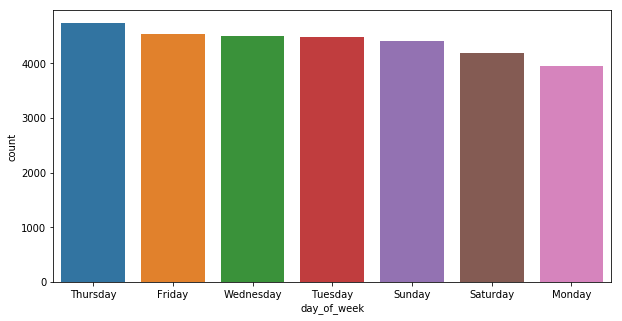

In [17]:
plt.figure(figsize=(10,5))
sns.countplot(data=dataset, 
              x='day_of_week', 
              order=dataset['day_of_week'].value_counts().index)
plt.show()

<p>Notamos claramente que o dia com maior movimentação de clientes é Quinta-Feira e o dia com menor movimentação é Segunda-Feira</p>

<h2>Hour</h2>

In [18]:
# Contagem das horas
hour_count = dataset['hour'].value_counts()
hour_count

12    2474
13    2397
14    1966
18    1884
17    1880
19    1855
10    1829
9     1824
11    1804
8     1801
15    1700
16    1688
20    1584
7     1252
21    1133
22     901
23     622
6      547
0      450
1      305
5      256
2      249
3      229
4      172
Name: hour, dtype: int64

<p>Como de se esperar, os horários da madrugada possuem menos movimentação.</p>

<p>A partir do array acima temos uma faixa de horário ideal para rodar um anúncio de promoção.</p>

In [19]:
# Quais são as horas cuja sua contagem é superior a mediana das contagens
hour_count[hour_count > hour_count.median()].keys().sort_values()

Int64Index([8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], dtype='int64')

In [25]:
pd.DataFrame(dataset.groupby(by=['day_of_week'])['hour'].value_counts()).loc['Saturday']

,hour
hour,
12,313
13,294
11,288
10,262
9,256
16,252
20,245
14,239
15,239


In [35]:
dataset.groupby(by=['categoria'])['day_of_week'].value_counts().loc['cafe']

day_of_week
Thursday     115
Friday       106
Wednesday    102
Saturday      95
Sunday        82
Tuesday       79
Monday        67
Name: day_of_week, dtype: int64

In [30]:
dataset['categoria'].value_counts()

restaurant                5826
store                     3461
school                    1728
doctor                    1203
grocery_or_supermarket    1103
bar                        996
storage                    985
lodging                    897
car_repair                 836
electronics_store          698
bakery                     664
cafe                       646
car_dealer                 626
hospital                   603
place_of_worship           528
gas_station                513
bank                       511
moving_company             496
gym                        460
shopping_mall              454
pharmacy                   439
furniture_store            420
beauty_salon               404
university                 353
park                       335
cultural_venue             326
home_goods_store           272
accounting                 233
pet_store                  220
stadium                    217
                          ... 
movie_theater               51
cemetery

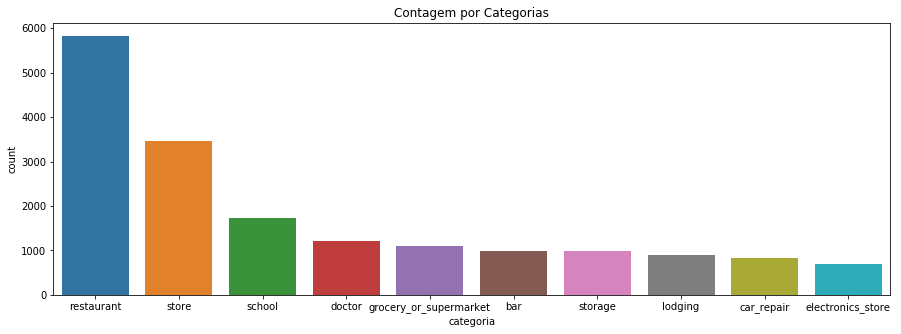

In [48]:
plt.figure(figsize=(15,5))
plt.title('Contagem por Categorias')
sns.countplot(data=dataset, 
              x = 'categoria', 
              order=dataset['categoria'].value_counts()[:10].index)
plt.show()

In [81]:
dataset.groupby(by='categoria')['dia'].value_counts()['restaurant']

dia
05    513
04    467
10    424
13    423
07    409
06    408
12    407
03    401
14    387
02    374
11    364
09    361
08    336
01    309
15    243
Name: dia, dtype: int64

In [86]:
dataset.groupby(by='categoria')['hour'].value_counts()['grocery_or_supermarket']

hour
13    84
14    82
19    80
12    75
9     74
10    68
8     65
17    63
16    62
11    61
15    55
20    55
18    52
7     37
21    36
22    36
6     29
23    22
0     19
1     18
5     10
3      7
4      7
2      6
Name: hour, dtype: int64